# Realestate Selling Price Predictor Model 
This project takes in a dataset of realestate listings with various features and makes a predictions on what the selling price will be. I decided to do realestate since I am interested in buying my own place, so I figured the analysis and modelling could help me better gauge what I should offer and whether the current price is overpriced or not

## Library Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import pickle

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

import random

## Exploratory Analysis

### Helper Functions

In [2]:
def remove_chars(chars, column):
    if (type(column[0]) != str):
        return column
    
    for c in chars:
        column = column.str.replace(c, '')
 
    return column

def clean_data(df):
    df.sqft = remove_chars(['$',','], df.sqft)
    df.sell_price = remove_chars(['$', ','], df.sell_price)
    df.ask_price_orig = remove_chars(['$', ','], df.ask_price_orig)
    df.ask_price_final = remove_chars(['$', ','], df.ask_price_final)
    df.maintenance_fee = remove_chars(['$', ','], df.maintenance_fee)
    df.property_tax = remove_chars(['$', ','], df.property_tax)
    
    df.loc[df.age == 'Old', 'age'] = str(random.randint(26,39))
    df.loc[df.age == 'New', 'age'] = str(random.randint(0,5))

    df.sqft = df.sqft.astype('int64')
    df.beds = df.beds.astype('int64')
    df.baths = df.baths.astype('int64')
    df.age = df.age.astype('int64')
    df.sell_price = df.sell_price.astype('int64')
    df.ask_price_orig = df.ask_price_orig.astype('int64')
    df.ask_price_final = df.ask_price_final.astype('int64')
    df.maintenance_fee = df.maintenance_fee.astype('float64')
    df.property_tax = df.property_tax.astype('float64')
    df.sold_date = df.sold_date.astype('datetime64')
    
    return df 

def rename_columns(df):
    
    df.rename({'Listing': 'listing', 'Address': 'address', 'City': 'city', 'Neighbourhood': 'neighbourhood', 'Beds': 'beds', 'Baths': 'baths',
          'Property Type': 'property_type', 'Unit Type': 'unit_type', 'Sold Date': 'sold_date', 'Selling Price': 'sell_price', 
          'Asking Price (Final)': 'ask_price_final', 'Asking Price (Original)': 'ask_price_orig', 'Sqft': 'sqft', 'Age': 'age',
          'Property Tax': 'property_tax', 'Ownership Type': 'ownership_type', 'Maintenance Fee': 'maintenance_fee', 'Rules': 'rules',
          'Zoning': 'zoning'}, axis=1, inplace=True)
       
    return df

### Load Raw Dataset

In [3]:
df = pd.read_csv('burnaby_solds_6m.csv')

### Analysis
The following is the analysis of the dataset

In [4]:
df.shape

(421, 19)

In [5]:
# Check front and back of dataset (eyeball it)
df.head()

,Listing,Address,City,Neighbourhood,Beds,Baths,Property Type,Unit Type,Sold Date,Selling Price,Asking Price (Final),Asking Price (Original),Sqft,Age,Property Tax,Ownership Type,Maintenance Fee,Rules,Zoning
0,R2448653,# 519 388 KOOTENAY STREET,Vancouver,Hastings Sunrise,2,1,Apartment,Upper Unit,2020-Apr-29,"$590,000","$599,800","$625,800",802,5,"$1,498.73",Freehold Strata,$389.71,"Pets Allowed, Rentals Allowed",C2-C
1,R2444219,# 901 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,Apartment,Upper Unit,2020-Mar-23,"$490,000","$525,000","$525,000",877,36,"$2,149.72",Freehold Strata,$344.10,"Pets Not Allowed, Rentals Allowed with Restric...",CD
2,R2451408,# 607 3760 ALBERT STREET,Burnaby,Vancouver Heights,1,1,Apartment,Inside Unit,2020-Jun-05,"$358,500","$374,900","$374,900",704,37,"$1,871.30",Freehold Strata,$241.60,"Pets Not Allowed, Rentals Allowed with Restric...",CD
3,R2452612,# 201 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,Apartment,Inside Unit,2020-May-12,"$420,000","$429,000","$429,000",876,36,"$1,395",Freehold Strata,$343.68,"Pets Not Allowed, Rentals Allowed with Restric...",CD
4,R2436217,# 405 3760 ALBERT STREET,Burnaby,Vancouver Heights,2,1,Apartment,Inside Unit,2020-Feb-20,"$485,000","$499,000","$499,000",864,38,"$2,155.41",Freehold Strata,$369,"Pets Not Allowed, Rentals Allowed with Restric...",CD


In [6]:
df.tail(12)

,Listing,Address,City,Neighbourhood,Beds,Baths,Property Type,Unit Type,Sold Date,Selling Price,Asking Price (Final),Asking Price (Original),Sqft,Age,Property Tax,Ownership Type,Maintenance Fee,Rules,Zoning
409,R2448997,# 204 4160 SARDIS STREET,Burnaby,Central Park BS,1,1,Apartment,Corner Unit,2020-May-10,"$400,000","$419,900","$419,900",760,45,"$1,745.63",Freehold Strata,$316.38,"Pets Not Allowed, Rentals Not Allowed",CD
410,R2428179,# 1205 4160 SARDIS STREET,Burnaby,Central Park BS,1,1,Apartment,Upper Unit,2020-Jan-20,"$424,000","$424,900","$424,900",715,45,"$1,764.37",Freehold Strata,$275.79,"Pets Not Allowed, Rentals Not Allowed",STRATA
411,R2428333,# 1406 4160 SARDIS STREET,Burnaby,Central Park BS,2,1,Apartment,Corner Unit,2020-Jan-21,"$470,000","$479,000","$479,000",938,43,"$2,049.63",Freehold Strata,$357,"Pets Not Allowed, Rentals Not Allowed",CD
412,R2417528,# 507 5645 BARKER AVENUE,Burnaby,Central Park BS,2,2,Apartment,1 Storey,2020-Jan-22,"$485,000","$499,000","$499,000",947,45,"$1,975.75",Freehold Strata,$365,"Pets Not Allowed, Rentals Not Allowed",STRATA
413,R2425550,# 1601 5652 PATTERSON AVENUE,Burnaby,Central Park BS,2,1,Apartment,"1 Storey, Upper Unit",2020-Jan-01,"$540,000","$568,800","$568,800",918,39,"$2,112.04",Freehold Strata,$354.09,"Pets Not Allowed, Rentals Not Allowed",CDRM5
414,R2448891,# 2103 5652 PATTERSON AVENUE,Burnaby,Central Park BS,2,1,Apartment,Penthouse,2020-May-06,"$548,000","$575,000","$575,000","1,061",38,"$2,271",Freehold Strata,$422.51,"Pets Not Allowed, Rentals Not Allowed",CD
415,R2456638,# 301 5565 INMAN AVENUE,Burnaby,Central Park BS,1,1,Apartment,Corner Unit,2020-May-20,"$451,000","$435,000","$435,000",734,30,"$1,465.88",Freehold Strata,$261.77,"Pets Allowed with Restrictions, Rentals Not Al...",CD
416,R2449470,# 210 5655 INMAN AVENUE,Burnaby,Central Park BS,1,1,Apartment,Inside Unit,2020-Apr-09,"$442,000","$448,000","$448,000",607,8,"$2,072.58",Freehold Strata,$195.85,"Pets Allowed with Restrictions, Rentals Allowed",CD
417,R2452076,# 208 3895 SANDELL STREET,Burnaby,Central Park BS,2,2,Apartment,Other,2020-May-08,"$598,000","$599,000","$599,000",929,13,"$2,474.03",Freehold Strata,$340.06,"Pets Allowed with Restrictions, Rentals Allowe...",CD
418,R2465048,# 403 5667 SMITH AVENUE,Burnaby,Central Park BS,1,1,Apartment,"1 Storey, Upper Unit",2020-Jun-20,"$449,000","$449,000","$449,000",685,23,"$1,997.24",Freehold Strata,$242,"Pets Allowed with Restrictions, Rentals Allowe...",CD


In [7]:
df.dtypes[df.dtypes=='object']

Listing                    object
Address                    object
City                       object
Neighbourhood              object
Property Type              object
Unit Type                  object
Sold Date                  object
Selling Price              object
Asking Price (Final)       object
Asking Price (Original)    object
Sqft                       object
Age                        object
Property Tax               object
Ownership Type             object
Maintenance Fee            object
Rules                      object
Zoning                     object
dtype: object

In [8]:
# Print out the features that are of type object
for feature in df.dtypes[df.dtypes == 'object'].index:
    print(feature)

Listing
Address
City
Neighbourhood
Property Type
Unit Type
Sold Date
Selling Price
Asking Price (Final)
Asking Price (Original)
Sqft
Age
Property Tax
Ownership Type
Maintenance Fee
Rules
Zoning


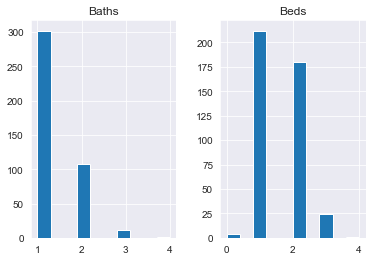

In [9]:
df.hist()
plt.show()

### Clean up column names

In [10]:
# rename columns to make it easier to work with in Pandas
rename_columns(df)

df.columns

Index(['listing', 'address', 'city', 'neighbourhood', 'beds', 'baths',
       'property_type', 'unit_type', 'sold_date', 'sell_price',
       'ask_price_final', 'ask_price_orig', 'sqft', 'age', 'property_tax',
       'ownership_type', 'maintenance_fee', 'rules', 'zoning'],
      dtype='object')

In [11]:
# clean columns (datatypes and symbols)
df = clean_data(df)

In [12]:
df.dtypes

listing                    object
address                    object
city                       object
neighbourhood              object
beds                        int64
baths                       int64
property_type              object
unit_type                  object
sold_date          datetime64[ns]
sell_price                  int64
ask_price_final             int64
ask_price_orig              int64
sqft                        int64
age                         int64
property_tax              float64
ownership_type             object
maintenance_fee           float64
rules                      object
zoning                     object
dtype: object

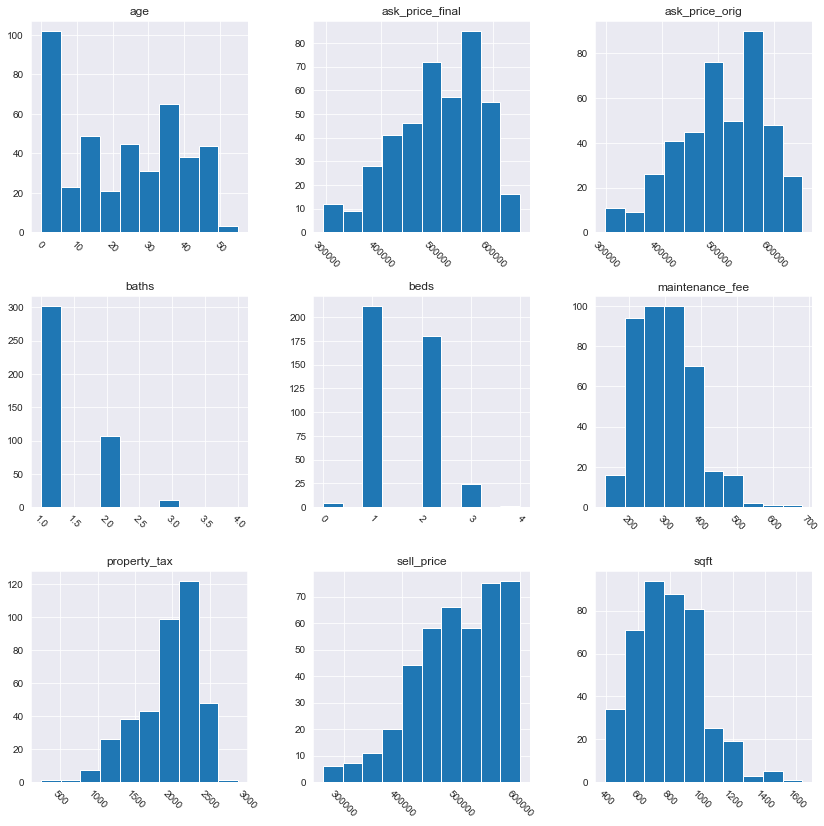

In [13]:
df.hist(figsize=(14, 14), xrot=-45)
plt.show()

Based on the histogram I noticed the following:
- The ask_price_original and ask_price_final are quite similar so I will investigate whether I should drop one of them
Results: If the ask final is different than ask_original it shows the seller voluntarily reduced their price to attract sellers. This information would be useful, but since sellers can relist as a new listings it erases the previous price. Overall, do to manipulation of listings it is not a useful stat, so we will drop the final_ask 

In [14]:
mask = df.ask_price_orig != df.ask_price_final 
df[mask]

,listing,address,city,neighbourhood,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price_orig,sqft,age,property_tax,ownership_type,maintenance_fee,rules,zoning
0,R2448653,# 519 388 KOOTENAY STREET,Vancouver,Hastings Sunrise,2,1,Apartment,Upper Unit,2020-04-29,590000,599800,625800,802,5,1498.730,Freehold Strata,389.710,"Pets Allowed, Rentals Allowed",C2-C
8,R2450652,# 1106 3920 HASTINGS STREET,Burnaby,Willingdon Heights,2,1,Apartment,"Corner Unit, Upper Unit",2020-05-14,520000,559900,575000,989,34,2347.530,Freehold Strata,336.910,"Pets Not Allowed, Rentals Not Allowed",CD
16,R2387925,# 301 5450 EMPIRE DRIVE,Burnaby,Capitol Hill BN,1,1,Apartment,Inside Unit,2019-11-24,305000,320000,340000,642,45,1333.580,Freehold Strata,253.090,"Pets Allowed with Restrictions, Rentals Allowe...",RM3
22,R2450845,# 42 6965 HASTINGS STREET,Burnaby,Sperling-Duthie,2,2,Townhouse,NaN,2020-05-18,555000,585000,599000,922,9,2386.520,Freehold Strata,309.780,"Pets Allowed with Restrictions, Rentals Allowe...",RM3
30,R2448419,# 3302 1888 GILMORE AVENUE,Burnaby,Brentwood Park,1,1,Apartment,Upper Unit,2020-05-02,485000,499000,549000,486,0,nan,Freehold Strata,196.900,"Pets Allowed, Rentals Allowed",CDRM5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,R2439916,# 1706 6333 SILVER AVENUE,Burnaby,Metrotown,1,1,Apartment,Inside Unit,2020-03-15,535000,559900,575000,512,5,2275.990,Freehold Strata,213.610,"Pets Allowed, Rentals Allowed with Restrictions",CD
387,R2441971,# 1805 4134 MAYWOOD STREET,Burnaby,Metrotown,2,2,Apartment,"Corner Unit, Upper Unit",2020-05-21,575000,584999,599999,942,35,2355.950,Freehold Strata,403.950,"Pets Not Allowed, Rentals Allowed with Restric...",CD
388,R2412849,# 704 4194 MAYWOOD STREET,Burnaby,Metrotown,1,1,Apartment,Inside Unit,2020-01-23,412500,429800,448500,746,35,1873.910,Freehold Strata,286.000,"Pets Not Allowed, Rentals Allowed with Restric...",APT
392,R2408991,# 905 4194 MAYWOOD STREET,Burnaby,Metrotown,2,1,Apartment,1 Storey,2019-12-28,470000,468000,499000,926,35,2138.130,Freehold Strata,392.200,"Pets Not Allowed, Rentals Allowed with Restric...",CD


In [15]:
print(len(df[mask]))

62


In [16]:
df[mask].describe()

,beds,baths,sell_price,ask_price_final,ask_price_orig,sqft,age,property_tax,maintenance_fee
count,62.000,62.000,62.000,62.000,62.000,62.000,62.000,58.000,62.000
mean,1.629,1.387,486869.161,501591.694,525433.806,829.290,24.790,1972.367,334.315
std,0.659,0.554,80301.157,84013.827,82544.180,196.995,14.942,403.831,100.800
min,0.000,1.000,295000.000,295000.000,325000.000,440.000,0.000,1038.330,160.510
25%,1.000,1.000,435250.000,449000.000,472425.000,701.250,11.750,1725.600,267.393
50%,2.000,1.000,485000.000,502450.000,529900.000,869.000,26.000,2025.810,332.410
75%,2.000,2.000,557250.000,577250.000,598750.000,941.750,36.750,2280.962,391.577
max,3.000,3.000,600000.000,625000.000,650000.000,1443.000,46.000,2879.640,681.950


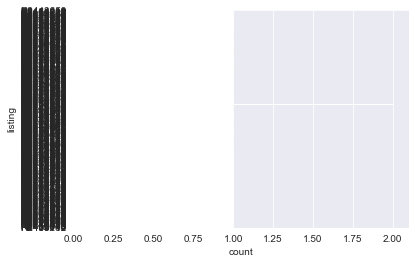

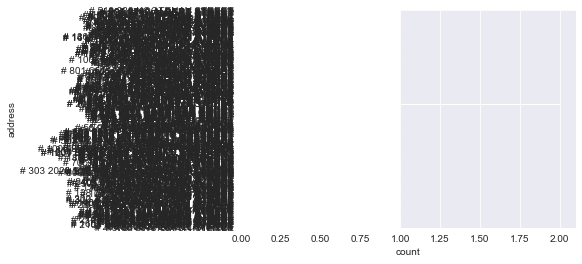

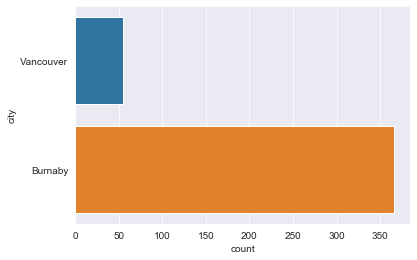

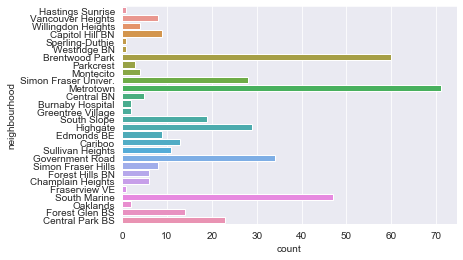

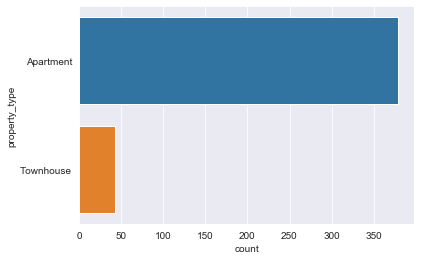

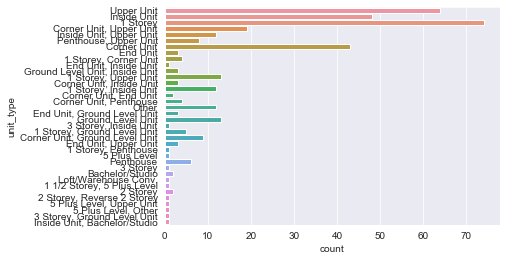

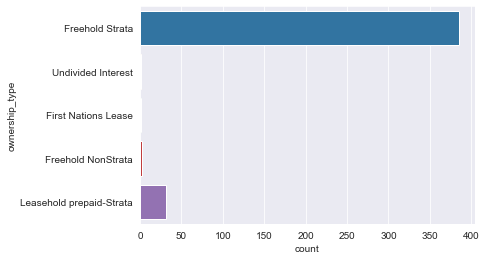

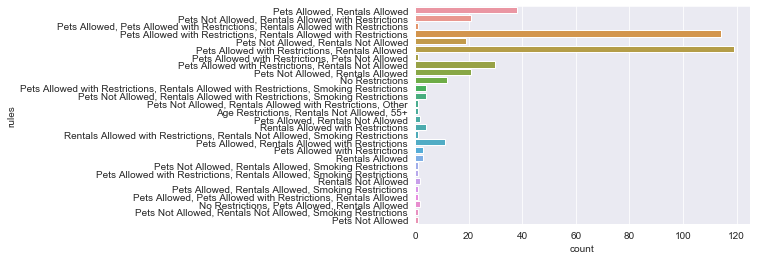

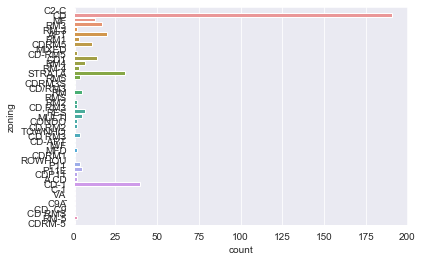

In [17]:
for feature in df.dtypes[df.dtypes == 'object'].index:
    sns.countplot(y=feature, data=df)
    plt.show()

### Segmentations

#### Bloxplots

In [18]:
df.dtypes[df.dtypes=='object']

listing           object
address           object
city              object
neighbourhood     object
property_type     object
unit_type         object
ownership_type    object
rules             object
zoning            object
dtype: object

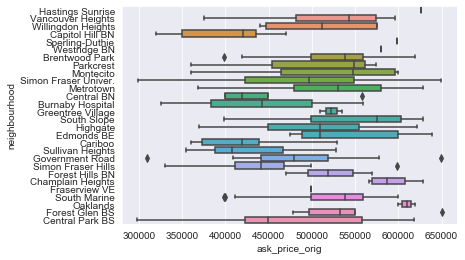

In [19]:
sns.boxplot(y='neighbourhood', x='ask_price_orig', data=df)
plt.show()

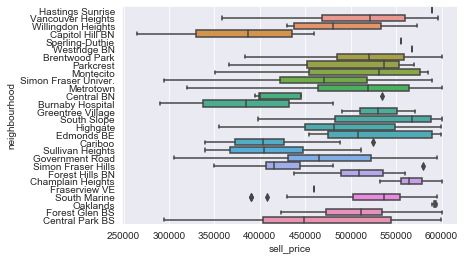

In [20]:
sns.boxplot(y='neighbourhood', x='sell_price', data=df)
plt.show()

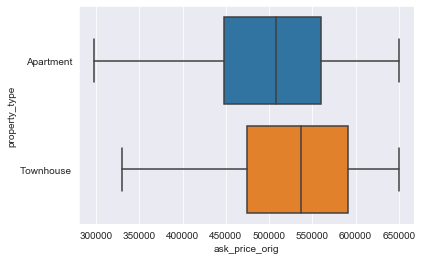

In [21]:
sns.boxplot(y='property_type', x='ask_price_orig', data=df)
plt.show()

### Violin Plots

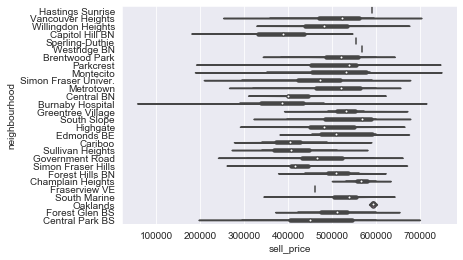

In [22]:
sns.violinplot(y='neighbourhood', x='sell_price', data=df)
plt.show()

## 3. Correlations

### Heatmap

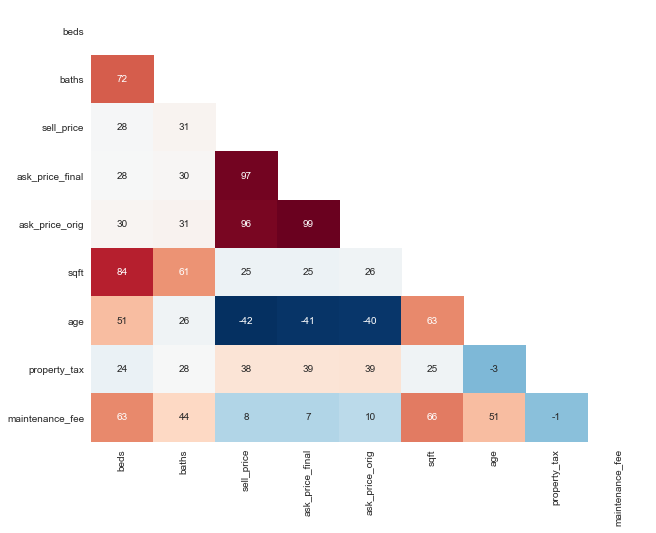

In [23]:
sns.set_style('white')
correlations = df.corr()

plt.figure(figsize=(10,8))

# mask to remove upper triangle of heatmap matric (just duplicate info)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

sns.heatmap(correlations * 100, 
            cmap='RdBu_r',
            annot=True,
            fmt='.0f',
            mask=mask, 
            cbar=False)
plt.show()

### Save dataset

In [24]:
df.to_csv('ea_burnaby_solds.csv', index=None)

## Data Cleaning

In [25]:
df = pd.read_csv('ea_burnaby_solds.csv')

In [26]:
df.address.nunique()

420

In [27]:
# remove duplicate observations
print('Before Dups removed:',df.shape)
df.drop_duplicates(inplace=True)
print('After Dups removed:',df.shape)

Before Dups removed: (421, 19)
After Dups removed: (420, 19)


In [28]:
df.columns

Index(['listing', 'address', 'city', 'neighbourhood', 'beds', 'baths',
       'property_type', 'unit_type', 'sold_date', 'sell_price',
       'ask_price_final', 'ask_price_orig', 'sqft', 'age', 'property_tax',
       'ownership_type', 'maintenance_fee', 'rules', 'zoning'],
      dtype='object')

In [29]:
df.dtypes

listing             object
address             object
city                object
neighbourhood       object
beds                 int64
baths                int64
property_type       object
unit_type           object
sold_date           object
sell_price           int64
ask_price_final      int64
ask_price_orig       int64
sqft                 int64
age                  int64
property_tax       float64
ownership_type      object
maintenance_fee    float64
rules               object
zoning              object
dtype: object

In [30]:
df.describe(include='int64')

,beds,baths,sell_price,ask_price_final,ask_price_orig,sqft,age
count,420.000,420.000,420.000,420.000,420.000,420.000,420.000
mean,1.540,1.314,492625.705,503215.988,506735.538,797.238,22.695
std,0.630,0.532,73209.140,76045.779,76207.349,211.067,15.878
min,0.000,1.000,265000.000,295000.000,298000.000,393.000,0.000
25%,1.000,1.000,444450.000,448000.000,449000.000,641.500,7.000
50%,1.000,1.000,498000.000,508000.000,509999.500,777.500,25.000
75%,2.000,2.000,555000.000,564175.000,568000.000,920.250,37.000
max,4.000,4.000,600000.000,649000.000,650000.000,1637.000,55.000


In [31]:
# Only Burnaby observations 
mask = df.city == 'Burnaby'
df = df[mask].copy()
df

,listing,address,city,neighbourhood,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price_orig,sqft,age,property_tax,ownership_type,maintenance_fee,rules,zoning
1,R2444219,# 901 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,Apartment,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",CD
2,R2451408,# 607 3760 ALBERT STREET,Burnaby,Vancouver Heights,1,1,Apartment,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",CD
3,R2452612,# 201 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,Apartment,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",CD
4,R2436217,# 405 3760 ALBERT STREET,Burnaby,Vancouver Heights,2,1,Apartment,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",CD
5,R2463150,# 108 3709 PENDER STREET,Burnaby,Willingdon Heights,1,1,Apartment,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",MF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,R2449470,# 210 5655 INMAN AVENUE,Burnaby,Central Park BS,1,1,Apartment,Inside Unit,2020-04-09,442000,448000,448000,607,8,2072.580,Freehold Strata,195.850,"Pets Allowed with Restrictions, Rentals Allowed",CD
417,R2452076,# 208 3895 SANDELL STREET,Burnaby,Central Park BS,2,2,Apartment,Other,2020-05-08,598000,599000,599000,929,13,2474.030,Freehold Strata,340.060,"Pets Allowed with Restrictions, Rentals Allowe...",CD
418,R2465048,# 403 5667 SMITH AVENUE,Burnaby,Central Park BS,1,1,Apartment,"1 Storey, Upper Unit",2020-06-20,449000,449000,449000,685,23,1997.240,Freehold Strata,242.000,"Pets Allowed with Restrictions, Rentals Allowe...",CD
419,R2435189,# 105 5577 SMITH AVENUE,Burnaby,Central Park BS,1,1,Apartment,"Corner Unit, Ground Level Unit",2020-02-18,405000,399000,399000,780,23,1817.210,Freehold Strata,303.500,"Pets Allowed with Restrictions, Rentals Allowe...",APT


In [32]:
df.shape

(365, 19)

In [33]:
# rename ask_price_orig
df.rename({'ask_price_orig': 'ask_price'}, axis=1, inplace=True)
df.columns

Index(['listing', 'address', 'city', 'neighbourhood', 'beds', 'baths',
       'property_type', 'unit_type', 'sold_date', 'sell_price',
       'ask_price_final', 'ask_price', 'sqft', 'age', 'property_tax',
       'ownership_type', 'maintenance_fee', 'rules', 'zoning'],
      dtype='object')

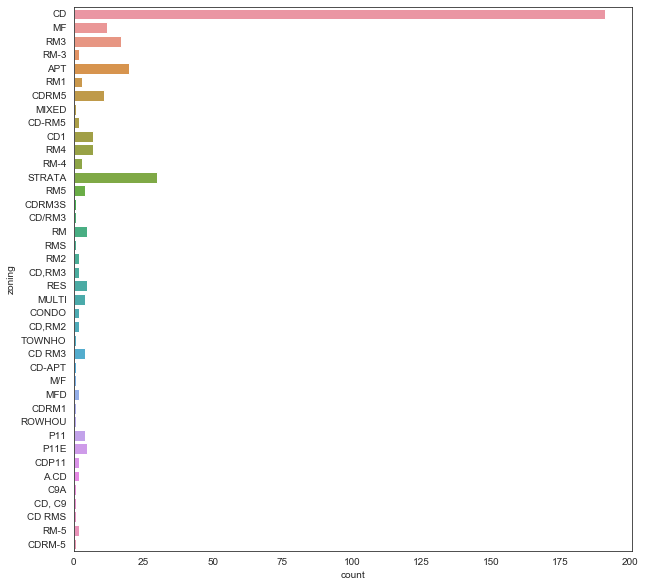

In [34]:
# plot all the zonings
plt.figure(figsize=(10,10))
sns.countplot(y='zoning', data=df)
plt.show()

In [35]:
df.replace(['MIXED','MF','M/F','MFD','ROWHOU','TOWNHO','RM1','RM5','RMS','RM2','RM-5','RM-4','RM/4','RM-4N','RM 9A','FM-1','RM3','RM-9A','RM-3A','RM-3','RM4','RS-1', 'RM','RM-9N','MF','STRATA','APT','CONDO','MULTI','RES','MC-1'], 'Residential', inplace=True)
df.replace(['C9A','C2C1','C2-C1','C-2B', 'C3A','C-3A C','C-7','C-C21','C-2C1','C1','IC-3','C3-A','C-2C','C-1','C2','C-2','C-3A'],'Commerical', inplace=True)
df.replace(['CDRM3S','CD/RM3','CD RM3','P11','P11E','A.CD','CDRM5','CD-RM5', 'CDRM1','CDP11','CD, C9','CD RMS','CD,C9','CD RM5','CDRM-5','CD,RM3','CD,RM2','CD-APT','CD-1','CD','CD - 1','FCCDD','CD1'],'CompDev', inplace=True)


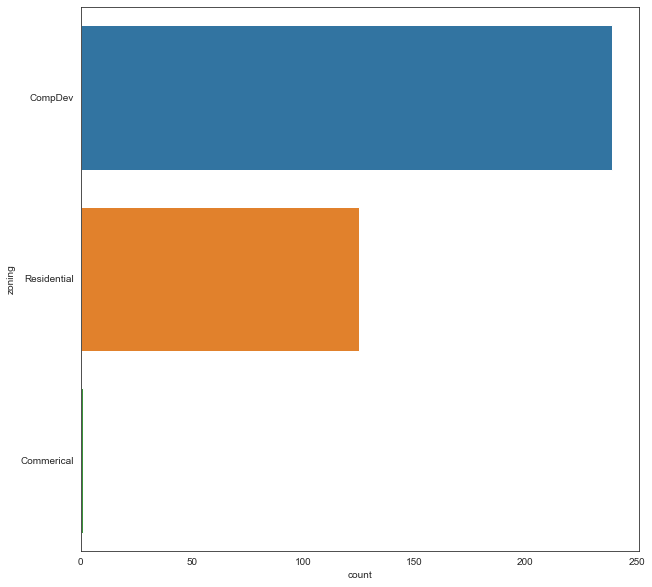

In [36]:
plt.figure(figsize=(10,10))
sns.countplot(y='zoning', data=df)
plt.show()

In [37]:
df.property_tax.isnull().sum()
print(df.shape)

(365, 19)


In [38]:
# remove observations with no property tax
df = df[df.property_tax.isnull() == False].copy()
df.shape

(342, 19)

In [39]:
df.isnull().sum()

listing             0
address             0
city                0
neighbourhood       0
beds                0
baths               0
property_type       0
unit_type          37
sold_date           0
sell_price          0
ask_price_final     0
ask_price           0
sqft                0
age                 0
property_tax        0
ownership_type      0
maintenance_fee     3
rules               1
zoning              0
dtype: int64

In [40]:
# Assign 'Townhouse' to all units where unit_type is null
print('Before:', df[df.unit_type == 'Townhouse']['unit_type'].count())
df.loc[df.unit_type.isnull() == True, 'unit_type'] = 'Townhouse'
print('After:', df[df.unit_type == 'Townhouse']['unit_type'].count())

Before: 0
After: 37


In [41]:
df.isnull().sum()

listing            0
address            0
city               0
neighbourhood      0
beds               0
baths              0
property_type      0
unit_type          0
sold_date          0
sell_price         0
ask_price_final    0
ask_price          0
sqft               0
age                0
property_tax       0
ownership_type     0
maintenance_fee    3
rules              1
zoning             0
dtype: int64

In [42]:
# Mark null rules as 'No Restrictions'
df.loc[df.rules.isnull(), 'rules'] = 'No Restrictions'

In [43]:
# Drop listings that are missing the maintenance fee. There are so few that it is not worth creating
# another column to show they are missing
mask = df.maintenance_fee.isnull()
df.dropna(subset=['maintenance_fee'], inplace=True)

In [44]:
df.isnull().sum()

listing            0
address            0
city               0
neighbourhood      0
beds               0
baths              0
property_type      0
unit_type          0
sold_date          0
sell_price         0
ask_price_final    0
ask_price          0
sqft               0
age                0
property_tax       0
ownership_type     0
maintenance_fee    0
rules              0
zoning             0
dtype: int64

In [45]:
# Convert property_type into integer values so algorithm will be able to use this field
df.replace('Apartment', 1, inplace=True)
df.replace('Townhouse', 2, inplace=True)

df.head()

,listing,address,city,neighbourhood,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,zoning
1,R2444219,# 901 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,1,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
2,R2451408,# 607 3760 ALBERT STREET,Burnaby,Vancouver Heights,1,1,1,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
3,R2452612,# 201 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,1,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
4,R2436217,# 405 3760 ALBERT STREET,Burnaby,Vancouver Heights,2,1,1,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
5,R2463150,# 108 3709 PENDER STREET,Burnaby,Willingdon Heights,1,1,1,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",Residential


In [46]:
# convert the column datatype to int64
df.property_type = df.property_type.astype('int64')

In [47]:
df.dtypes

listing             object
address             object
city                object
neighbourhood       object
beds                 int64
baths                int64
property_type        int64
unit_type           object
sold_date           object
sell_price           int64
ask_price_final      int64
ask_price            int64
sqft                 int64
age                  int64
property_tax       float64
ownership_type      object
maintenance_fee    float64
rules               object
zoning              object
dtype: object

In [48]:
df.neighbourhood.unique()

array(['Vancouver Heights', 'Willingdon Heights', 'Capitol Hill BN',
       'Sperling-Duthie', 'Westridge BN', 'Brentwood Park', 'Parkcrest',
       'Montecito', 'Simon Fraser Univer.', 'Central BN',
       'Burnaby Hospital', 'Greentree Village', 'South Slope', 'Highgate',
       'Edmonds BE', 'Cariboo', 'Sullivan Heights', 'Government Road',
       'Simon Fraser Hills', 'Forest Hills BN', 'Oaklands',
       'Forest Glen BS', 'Metrotown', 'Central Park BS'], dtype=object)

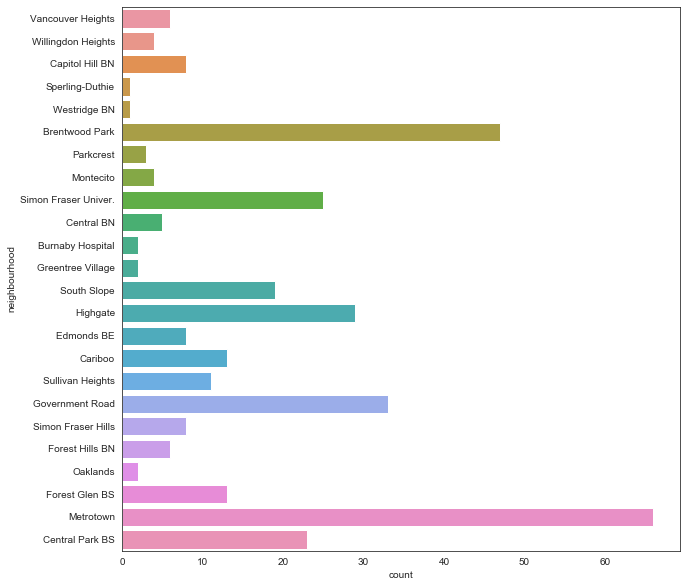

In [49]:
plt.figure(figsize=(10,10))
sns.countplot(y='neighbourhood', data=df)
plt.show()

In [50]:
# Combine these neighbourhoods into one
df.loc[df.neighbourhood == 'Sperling-Duthie', 'neighbourhood'] = 'Westridge BN'

In [51]:
df.columns

Index(['listing', 'address', 'city', 'neighbourhood', 'beds', 'baths',
       'property_type', 'unit_type', 'sold_date', 'sell_price',
       'ask_price_final', 'ask_price', 'sqft', 'age', 'property_tax',
       'ownership_type', 'maintenance_fee', 'rules', 'zoning'],
      dtype='object')

In [52]:
df.zoning.unique()

array(['CompDev', 'Residential'], dtype=object)

In [53]:
df.shape

(339, 19)

### Save Cleaned Dataset

In [54]:
df.to_csv('cleaned_burnaby_6m.csv', index=None)

## Feature Engineering

In [55]:
def drop_columns(columns):
    df.drop(columns, axis=1, inplace=True)

def box_plot(y, x, df, label_size=15, tick_size=12):
    b = sns.boxplot(y=y, x=x, data=df)
    b.set_xlabel(x,fontsize=label_size)
    b.set_ylabel(y,fontsize=label_size)
    b.tick_params(labelsize=tick_size)
    plt.show()
    
def violin_plot(y, x, df, label_size=15, tick_size=12):
    b = sns.violinplot(y=y, x=x, data=df)
    b.set_xlabel(x,fontsize=label_size)
    b.set_ylabel(y,fontsize=label_size)
    b.tick_params(labelsize=tick_size)
    plt.show()

### Load Cleaned Dataset

In [56]:
df = pd.read_csv('cleaned_burnaby_6m.csv')
print(df.shape)

(339, 19)


In [57]:
df.head()

,listing,address,city,neighbourhood,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,zoning
0,R2444219,# 901 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,1,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
1,R2451408,# 607 3760 ALBERT STREET,Burnaby,Vancouver Heights,1,1,1,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
2,R2452612,# 201 3740 ALBERT STREET,Burnaby,Vancouver Heights,2,1,1,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
3,R2436217,# 405 3760 ALBERT STREET,Burnaby,Vancouver Heights,2,1,1,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",CompDev
4,R2463150,# 108 3709 PENDER STREET,Burnaby,Willingdon Heights,1,1,1,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",Residential


In [58]:
# create pps column (ask_price / sqft)
# We are trying to calculate the sell_price, so let's use the ask_price to get asking price-per-square-foot
df['pps'] = np.round(df.ask_price / df.sqft, 0).astype(int)

In [59]:
df.sold_date.head()

0    2020-03-23
1    2020-06-05
2    2020-05-12
3    2020-02-20
4    2020-06-10
Name: sold_date, dtype: object

In [60]:
# Break up sold date into year and month
df['sold_year'] = pd.DatetimeIndex(df['sold_date']).year
df['sold_month'] = pd.DatetimeIndex(df['sold_date']).month

df.groupby(['sold_year', 'sold_month'])[['sell_price','sqft','pps']].agg(['sum','mean','count']).round(0)

sell_price                    sqft                  pps  \
                            sum       mean count    sum    mean count    sum   
sold_year sold_month                                                           
2019      10             460000 460000.000     1    950 950.000     1    525   
          11            1240000 413333.000     3   2328 776.000     3   1686   
          12            5274500 479500.000    11   9643 877.000    11   6503   
2020      1            30276326 488328.000    62  51733 834.000    62  39289   
          2            35016598 493192.000    71  57486 810.000    71  46848   
          3            31781488 488946.000    65  53502 823.000    65  41692   
          4            14069000 468967.000    30  24298 810.000    30  18977   
          5            23401400 477580.000    49  40268 822.000    49  30378   
          6            22780700 484696.000    47  36899 785.000    47  31932   

                                    
                        mean count  
sold_year sold_month                
2019      10         525.000     1  
          11         562.000     3  
          12         591.000    11  
2020      1          634.000    62  
          2          660.000    71  
          3          641.000    65  
          4          633.000    30  
          5          620.000    49  
          6          679.000    47

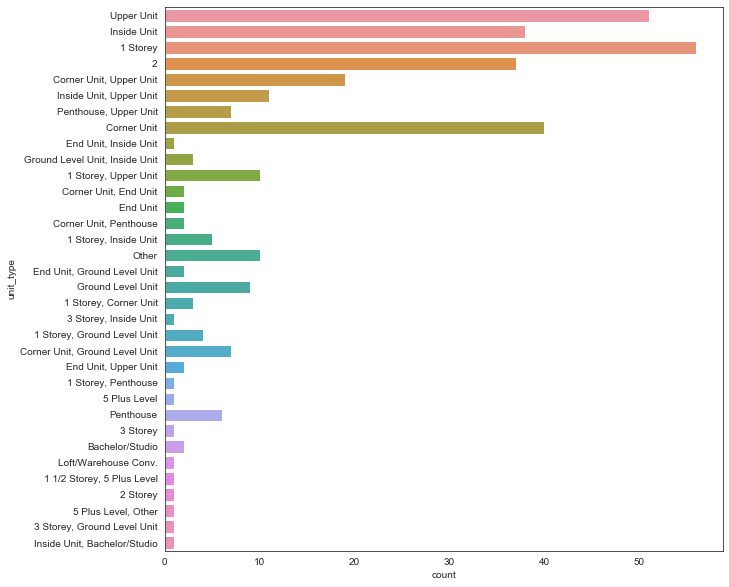

In [61]:
plt.figure(figsize=(10,10))
sns.countplot(y='unit_type', data=df)
plt.show()

In [62]:
# Break unit_type into indicator variables (based on barchart above)
df['ground_unit'] = (df.unit_type.str.contains('Ground', na=False)==True).astype('int64')
df['penthouse_unit'] = (df.unit_type.str.contains('Penthouse', na=False)==True).astype('int64')
df['studio_unit'] = (df.unit_type.str.contains('Studio', na=False)==True).astype('int64')
df['corner_unit'] = (df.unit_type.str.contains('Corner', na=False)==True).astype('int64')
df['end_unit'] = (df.unit_type.str.contains('End', na=False)==True).astype('int64')
df['upper_unit'] = (df.unit_type.str.contains('Upper', na=False)==True).astype('int64')
df['inside_unit'] = (df.unit_type.str.contains('Inside', na=False)==True).astype('int64')
df['townhouse'] = (df.property_type[df.property_type == 2] == 2).astype('int64')

In [63]:
df.townhouse.fillna(0, inplace=True)

In [64]:
mask = (df.ground_unit == 0) & (df.penthouse_unit == 0) & (df.studio_unit == 0) & (df.corner_unit == 0) & (df.end_unit == 0) & (df.upper_unit == 0) & (df.inside_unit == 0) & (df.townhouse == 0)

df[mask].head()

,listing,address,city,neighbourhood,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,zoning,pps,sold_year,sold_month,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse
4,R2463150,# 108 3709 PENDER STREET,Burnaby,Willingdon Heights,1,1,1,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",Residential,564,2020,6,0,0,0,0,0,0,0,0.000
8,R2453402,# 304 4307 HASTINGS STREET,Burnaby,Vancouver Heights,1,1,1,1 Storey,2020-05-05,560000,569000,569000,624,5,2267.330,Freehold Strata,291.340,"Pets Allowed, Rentals Allowed",CompDev,912,2020,5,0,0,0,0,0,0,0,0.000
9,R2418061,# 303 4307 HASTINGS STREET,Burnaby,Vancouver Heights,1,1,1,1 Storey,2020-01-07,553000,588000,588000,624,5,2301.430,Freehold Strata,276.780,"Pets Allowed with Restrictions, Rentals Allowed",CompDev,942,2020,1,0,0,0,0,0,0,0,0.000
17,R2431842,# 24 5988 HASTINGS STREET,Burnaby,Capitol Hill BN,1,1,1,1 Storey,2020-02-03,440000,439900,439900,730,26,2058.050,Freehold Strata,208.520,"Pets Allowed with Restrictions, Rentals Allowe...",CompDev,603,2020,2,0,0,0,0,0,0,0,0.000
29,R2427269,# 1306 2008 ROSSER AVENUE,Burnaby,Brentwood Park,1,1,1,1 Storey,2020-01-16,575000,525000,525000,587,5,2361.790,Freehold Strata,334.460,"Pets Allowed with Restrictions, Rentals Allowed",CompDev,894,2020,1,0,0,0,0,0,0,0,0.000


In [65]:
# create dataframe to check unit stats
df_units = pd.DataFrame([['ground_unit', df['ground_unit'].sum()],
                       ['penthouse_unit', df['penthouse_unit'].sum()],
                        ['studio_unit', df['studio_unit'].sum()],
                       ['corner_unit', df['corner_unit'].sum()],
                        ['end_unit', df['end_unit'].sum()],
                       ['upper_unit', df['upper_unit'].sum()],
                       ['inside_unit', df['inside_unit'].sum()],
                        ['townhouse', df['townhouse'].sum()]],
                       columns=['unit_type', 'number'])

df_units

,unit_type,number
0,ground_unit,26.000
1,penthouse_unit,16.000
2,studio_unit,3.000
3,corner_unit,73.000
4,end_unit,9.000
5,upper_unit,100.000
6,inside_unit,60.000
7,townhouse,37.000


In [66]:
df_units.number.sum()

324.0

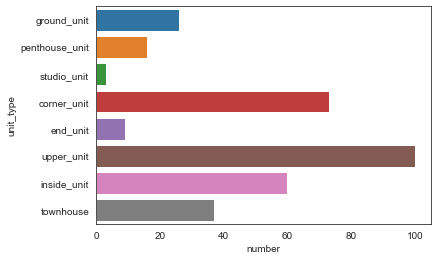

In [67]:
sns.barplot(x='number',y='unit_type', data=df_units)
plt.show()

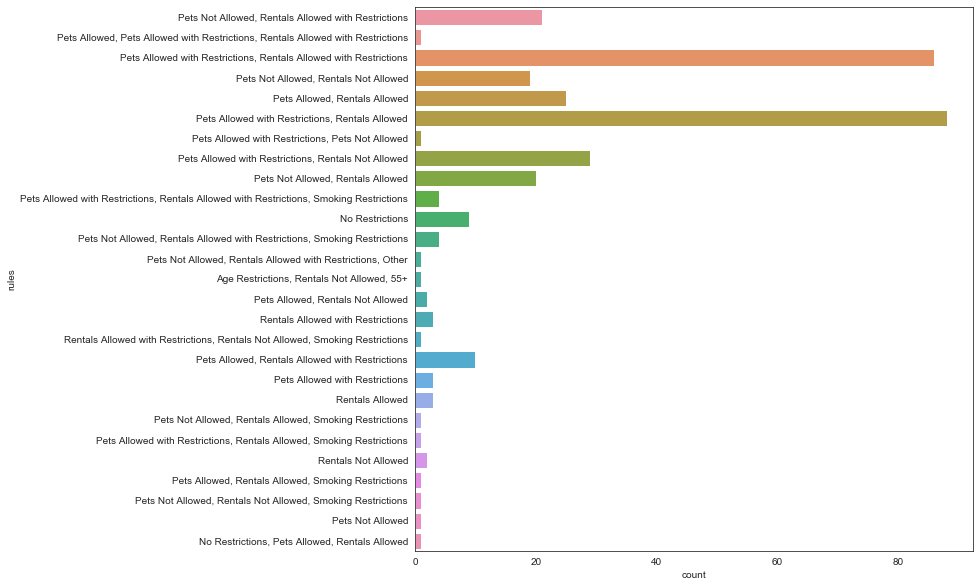

In [68]:
plt.figure(figsize=(10,10))
sns.countplot(y='rules', data=df)
plt.show()

In [69]:
# Create indicator variables for restrictions
df['age_restricted'] = (df.rules.str.contains('Age Restrictions', na=False)==True).astype('int64')
df['rentals_allowed'] = (df.rules.str.contains('Rentals Allowed', na=False)==True).astype('int64')
df['pets_allowed'] = (df.rules.str.contains('Pets Allowed', na=False)==True).astype('int64')
df['no_smoking'] = (df.rules.str.contains('Smoking Restrictions', na=False)==True).astype('int64')
df['no_restrictions'] = (df.rules.str.contains('No Restrictions', na=False)==True).astype('int64')

In [70]:
# visual check -- passed
pd.set_option('display.max_rows', 150)
df[['rules', 'age_restricted', 'rentals_allowed', 'pets_allowed', 'no_smoking','no_restrictions']].head()

,rules,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions
0,"Pets Not Allowed, Rentals Allowed with Restric...",0,1,0,0,0
1,"Pets Not Allowed, Rentals Allowed with Restric...",0,1,0,0,0
2,"Pets Not Allowed, Rentals Allowed with Restric...",0,1,0,0,0
3,"Pets Not Allowed, Rentals Allowed with Restric...",0,1,0,0,0
4,"Pets Allowed, Pets Allowed with Restrictions, ...",0,1,1,0,0


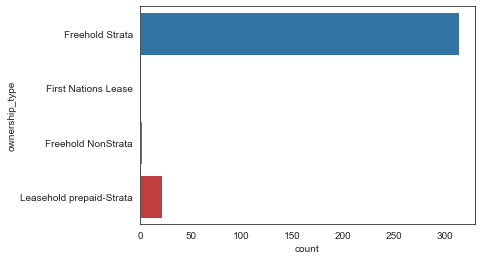

In [71]:
sns.countplot(y='ownership_type', data=df)
plt.show()


In [72]:
# Combine less common ownership types in one class called 'Others'
df.ownership_type.replace(['Leasehold prepaid-NonStrata','Leasehold prepaid-Strata',
                          'Shares in Co-operative','Undivided Interest', 'First Nations Lease',
                          'Freehold NonStrata'], 'Other', inplace=True)

In [73]:
df.ownership_type.unique()

array(['Freehold Strata', 'Other'], dtype=object)

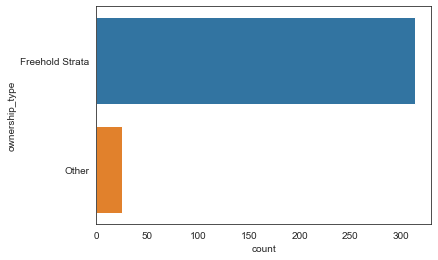

In [74]:
sns.countplot(y='ownership_type', data=df)
plt.show()

# if there are very few observations for 'Other', then drop the column (Model training will just overfit it)

In [75]:
# Bin age into the following groups
df['building_age'] = None

new = df.age.between(0, 5, inclusive=True)
df.loc[new,'building_age']='New'

newish = df.age.between(6, 12, inclusive=True)
df.loc[newish,'building_age']='Newish'

lived_in = df.age.between(13, 25, inclusive=True)
df.loc[lived_in,'building_age']='Lived In'

old = df.age.between(26, 39,  inclusive=True)
df.loc[old,'building_age']='Old'

very_old = df.age >= 40
df.loc[very_old,'building_age']='Very Old'

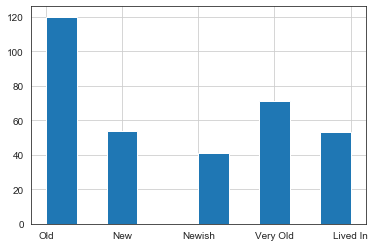

In [76]:
df.building_age.hist()
plt.show()

df.groupby('building_age')['sell_price'].mean().astype(int)



In [77]:
print(df.dtypes[df.dtypes=='object'])
print(df.dtypes[df.dtypes!='object'])

listing           object
address           object
city              object
neighbourhood     object
unit_type         object
sold_date         object
ownership_type    object
rules             object
zoning            object
building_age      object
dtype: object
beds                 int64
baths                int64
property_type        int64
sell_price           int64
ask_price_final      int64
ask_price            int64
sqft                 int64
age                  int64
property_tax       float64
maintenance_fee    float64
pps                  int32
sold_year            int64
sold_month           int64
ground_unit          int64
penthouse_unit       int64
studio_unit          int64
corner_unit          int64
end_unit             int64
upper_unit           int64
inside_unit          int64
townhouse          float64
age_restricted       int64
rentals_allowed      int64
pets_allowed         int64
no_smoking           int64
no_restrictions      int64
dtype: object


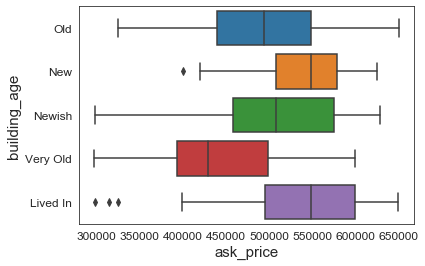

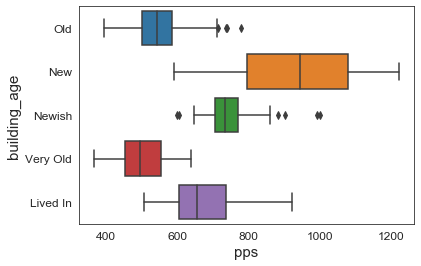

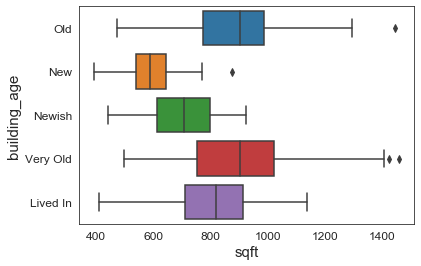

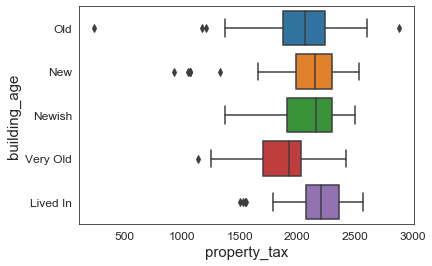

In [78]:
box_plot('building_age', 'ask_price', df)
box_plot('building_age', 'pps', df)
box_plot('building_age', 'sqft', df)
box_plot('building_age', 'property_tax', df)

In [79]:
df.columns

Index(['listing', 'address', 'city', 'neighbourhood', 'beds', 'baths',
       'property_type', 'unit_type', 'sold_date', 'sell_price',
       'ask_price_final', 'ask_price', 'sqft', 'age', 'property_tax',
       'ownership_type', 'maintenance_fee', 'rules', 'zoning', 'pps',
       'sold_year', 'sold_month', 'ground_unit', 'penthouse_unit',
       'studio_unit', 'corner_unit', 'end_unit', 'upper_unit', 'inside_unit',
       'townhouse', 'age_restricted', 'rentals_allowed', 'pets_allowed',
       'no_smoking', 'no_restrictions', 'building_age'],
      dtype='object')

In [80]:
# rank if unit sold over,under, or same as ask price
under_asking = df.sell_price < df.ask_price
over_asking = df.sell_price > df.ask_price
at_asking = df.sell_price == df.ask_price

df.loc[under_asking,'sold']='under_asking'
df.loc[over_asking,'sold']='over_asking'
df.loc[at_asking,'sold']='at_asking'

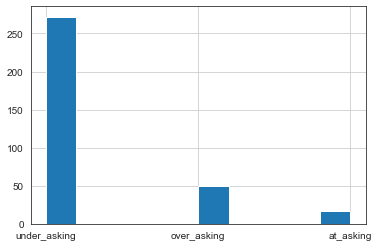

In [81]:
df.sold.hist()
plt.show()

In [82]:
# just some analysis
bed_and_bath_mask = (df.beds == 2) & (df.baths == 1)
age_mask = df.building_age.isin(['Lived In','Old','Very Old'])
mask = bed_and_bath_mask# & age_mask

df_neighbourhoods = df[mask].groupby('neighbourhood')['sell_price'].agg(['mean','min','max','std','count']).round(0)
df_neighbourhoods.sort_values(by='mean', ascending=True)

,mean,min,max,std,count
neighbourhood,,,,,
Parkcrest,366000.000,366000,366000,nan,1
Simon Fraser Hills,375500.000,350000,401000,36062.000,2
Cariboo,399312.000,365000,427000,20772.000,8
Government Road,406700.000,380000,435000,20663.000,5
Highgate,408900.000,355000,460000,40719.000,5
Sullivan Heights,415000.000,415000,415000,nan,1
Vancouver Heights,465000.000,420000,490000,39051.000,3
Forest Hills BN,472333.000,438000,490000,29738.000,3
Burnaby Hospital,480000.000,480000,480000,nan,1


In [83]:
df.groupby(['beds','baths']).agg('sum')

property_type  sell_price  ask_price_final  ask_price    sqft  \
beds baths                                                                  
0    1                  3     1094900          1127700    1147700    1386   
1    1                160    70918502         72575447   72928247  101349   
2    1                 77    32940900         33802587   34010685   64886   
     2                 99    47592410         48508347   48909460   83015   
     3                  2      560000           549000     549000    1229   
3    2                 23     7676800          7922400    8022400   17038   
     3                 12     3516500          3496789    3613989    8204   

             age  property_tax  maintenance_fee     pps  sold_year  \
beds baths                                                           
0    1        73      4296.570          622.480    2575       6060   
1    1      2841    301581.330        39197.620  114258     311074   
2    1      2555    141321.560        23312.140   36965     141396   
     2      2346    193324.410        30120.270   53868     181796   
     3        28      2418.280          369.960     447       2020   
3    2       534     30343.990         6028.500    6620      28279   
     3       310     15238.150         3169.000    3097      14140   

            sold_month  ground_unit  penthouse_unit  studio_unit  corner_unit  \
beds baths                                                                      
0    1              14            0               0            1            0   
1    1             542            7               8            2           21   
2    1             281            8               4            0           19   
     2             304            8               3            0           30   
     3               3            0               0            0            0   
3    2              53            2               1            0            3   
     3              24            1               0            0            0   

            end_unit  upper_unit  inside_unit  townhouse  age_restricted  \
beds baths                                                                 
0    1             0           0            2      0.000               0   
1    1             5          57           38      6.000               1   
2    1             3          19           11      7.000               0   
     2             1          22            9      9.000               0   
     3             0           0            0      1.000               0   
3    2             0           2            0      9.000               0   
     3             0           0            0      5.000               0   

            rentals_allowed  pets_allowed  no_smoking  no_restrictions  
beds baths                                                              
0    1                    2             2           0                0  
1    1                  124           122           7                7  
2    1                   55            42           3                1  
     2                   70            65           2                2  
     3                    1             1           0                0  
3    2                   13            13           1                0  
     3                    6             7           0                0

In [84]:
# Create dummy variables for the following categorical features
df =  pd.get_dummies(df, columns=['zoning','neighbourhood','building_age','sold'])

df.head()

,listing,address,city,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,pps,sold_year,sold_month,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_CompDev,zoning_Residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old,sold_at_asking,sold_over_asking,sold_under_asking
0,R2444219,# 901 3740 ALBERT STREET,Burnaby,2,1,1,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",599,2020,3,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,R2451408,# 607 3760 ALBERT STREET,Burnaby,1,1,1,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",533,2020,6,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,R2452612,# 201 3740 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",490,2020,5,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,R2436217,# 405 3760 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",578,2020,2,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4,R2463150,# 108 3709 PENDER STREET,Burnaby,1,1,1,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",564,2020,6,0,0,0,0,0,0,0,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [85]:
df.columns

Index(['listing', 'address', 'city', 'beds', 'baths', 'property_type',
       'unit_type', 'sold_date', 'sell_price', 'ask_price_final', 'ask_price',
       'sqft', 'age', 'property_tax', 'ownership_type', 'maintenance_fee',
       'rules', 'pps', 'sold_year', 'sold_month', 'ground_unit',
       'penthouse_unit', 'studio_unit', 'corner_unit', 'end_unit',
       'upper_unit', 'inside_unit', 'townhouse', 'age_restricted',
       'rentals_allowed', 'pets_allowed', 'no_smoking', 'no_restrictions',
       'zoning_CompDev', 'zoning_Residential', 'neighbourhood_Brentwood Park',
       'neighbourhood_Burnaby Hospital', 'neighbourhood_Capitol Hill BN',
       'neighbourhood_Cariboo', 'neighbourhood_Central BN',
       'neighbourhood_Central Park BS', 'neighbourhood_Edmonds BE',
       'neighbourhood_Forest Glen BS', 'neighbourhood_Forest Hills BN',
       'neighbourhood_Government Road', 'neighbourhood_Greentree Village',
       'neighbourhood_Highgate', 'neighbourhood_Metrotown',
       'neigh

In [86]:
df.shape

(339, 66)

In [87]:
# percetages for unit sales that sold
fun = lambda x: np.round((x.count() / df.shape[0]) * 100)
df.groupby(['sold_under_asking','sold_over_asking','sold_at_asking'])['listing'].apply(fun)

sold_under_asking  sold_over_asking  sold_at_asking
0                  0                 1                 5.000
                   1                 0                15.000
1                  0                 0                80.000
Name: listing, dtype: float64

In [88]:
df.groupby(['sold_year','sold_month'])[['sold_under_asking','sold_over_asking','sold_at_asking']].agg(['sum'])

sold_under_asking sold_over_asking sold_at_asking
                                   sum              sum            sum
sold_year sold_month                                                  
2019      10                         1                0              0
          11                         3                0              0
          12                        10                1              0
2020      1                         54                7              1
          2                         49               17              5
          3                         48               14              3
          4                         28                1              1
          5                         42                5              2
          6                         37                5              5

In [89]:
df.columns

Index(['listing', 'address', 'city', 'beds', 'baths', 'property_type',
       'unit_type', 'sold_date', 'sell_price', 'ask_price_final', 'ask_price',
       'sqft', 'age', 'property_tax', 'ownership_type', 'maintenance_fee',
       'rules', 'pps', 'sold_year', 'sold_month', 'ground_unit',
       'penthouse_unit', 'studio_unit', 'corner_unit', 'end_unit',
       'upper_unit', 'inside_unit', 'townhouse', 'age_restricted',
       'rentals_allowed', 'pets_allowed', 'no_smoking', 'no_restrictions',
       'zoning_CompDev', 'zoning_Residential', 'neighbourhood_Brentwood Park',
       'neighbourhood_Burnaby Hospital', 'neighbourhood_Capitol Hill BN',
       'neighbourhood_Cariboo', 'neighbourhood_Central BN',
       'neighbourhood_Central Park BS', 'neighbourhood_Edmonds BE',
       'neighbourhood_Forest Glen BS', 'neighbourhood_Forest Hills BN',
       'neighbourhood_Government Road', 'neighbourhood_Greentree Village',
       'neighbourhood_Highgate', 'neighbourhood_Metrotown',
       'neigh

In [90]:
df.rename({'zoning_Commerical': 'zoning_commerical'}, axis=1, inplace=True)
df.rename({'zoning_CompDev': 'zoning_compdev'}, axis=1, inplace=True)
df.rename({'zoning_Residential': 'zoning_residential'}, axis=1, inplace=True)
df.rename({'ownership_type_Freehold NonStrata': 'freehold_nonstrata'}, axis=1, inplace=True)
df.rename({'ownership_type_Freehold Strata': 'freehold_strata'}, axis=1, inplace=True)
df.rename({'ownership_type_Leasehold prepaid-NonStrata': 'leasehold_prepaid_nonstrata'}, axis=1, inplace=True)
df.rename({'ownership_type_Leasehold prepaid-Strata': 'leasehold_prepaid_strata'}, axis=1, inplace=True)
df.rename({'ownership_type_Shares in Co-operative': 'shares_in_coooperative'}, axis=1, inplace=True)
df.rename({'ownership_type_Undivided Interest': 'undivided_interest'}, axis=1, inplace=True)


In [91]:
df.columns

Index(['listing', 'address', 'city', 'beds', 'baths', 'property_type',
       'unit_type', 'sold_date', 'sell_price', 'ask_price_final', 'ask_price',
       'sqft', 'age', 'property_tax', 'ownership_type', 'maintenance_fee',
       'rules', 'pps', 'sold_year', 'sold_month', 'ground_unit',
       'penthouse_unit', 'studio_unit', 'corner_unit', 'end_unit',
       'upper_unit', 'inside_unit', 'townhouse', 'age_restricted',
       'rentals_allowed', 'pets_allowed', 'no_smoking', 'no_restrictions',
       'zoning_compdev', 'zoning_residential', 'neighbourhood_Brentwood Park',
       'neighbourhood_Burnaby Hospital', 'neighbourhood_Capitol Hill BN',
       'neighbourhood_Cariboo', 'neighbourhood_Central BN',
       'neighbourhood_Central Park BS', 'neighbourhood_Edmonds BE',
       'neighbourhood_Forest Glen BS', 'neighbourhood_Forest Hills BN',
       'neighbourhood_Government Road', 'neighbourhood_Greentree Village',
       'neighbourhood_Highgate', 'neighbourhood_Metrotown',
       'neigh

In [92]:
df.shape

(339, 66)

In [93]:
df_restrictions = df.groupby(['rentals_allowed','pets_allowed','no_smoking','no_restrictions','age_restricted'])['sell_price'].agg(['mean']).round(0)
df_restrictions.sort_values(by='mean', ascending=True)

,,,,,mean
rentals_allowed,pets_allowed,no_smoking,no_restrictions,age_restricted,
0,0,0,0,1,351000.000
1,0,0,0,0,462876.000
0,1,0,0,0,468871.000
1,0,1,0,0,475833.000
0,0,0,0,0,477195.000
1,1,0,0,0,492219.000
0,0,0,1,0,494688.000
1,1,1,0,0,512667.000
0,0,1,0,0,528000.000


In [94]:
print(df.groupby(['rentals_allowed'])['sell_price'].agg(['mean']).round(0))
print(df.groupby(['pets_allowed'])['sell_price'].agg(['mean']).round(0))
print(df.groupby(['no_smoking'])['sell_price'].agg(['mean']).round(0))
print(df.groupby(['no_restrictions'])['sell_price'].agg(['mean']).round(0))
print(df.groupby(['age_restricted'])['sell_price'].agg(['mean']).round(0))

                      mean
rentals_allowed           
0               474117.000
1               487306.000
                   mean
pets_allowed           
0            470144.000
1            489673.000
                 mean
no_smoking           
0          484175.000
1          496846.000
                      mean
no_restrictions           
0               484203.000
1               499719.000
                     mean
age_restricted           
0              485056.000
1              351000.000


In [95]:
df.age_restricted.sum()

1

##### Percent Drop Stats

In [96]:
mask = df.sold_under_asking == True
df_drop = df[mask].copy()

df_drop.insert(0, 'percent_drop', np.round((df_drop.ask_price - df_drop.sell_price) / df_drop.ask_price, 2))
df_drop.head()

,percent_drop,listing,address,city,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,pps,sold_year,sold_month,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old,sold_at_asking,sold_over_asking,sold_under_asking
0,0.070,R2444219,# 901 3740 ALBERT STREET,Burnaby,2,1,1,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",599,2020,3,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,0.040,R2451408,# 607 3760 ALBERT STREET,Burnaby,1,1,1,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",533,2020,6,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,0.020,R2452612,# 201 3740 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",490,2020,5,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,0.030,R2436217,# 405 3760 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",578,2020,2,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
5,0.040,R2431467,# 205 3709 PENDER STREET,Burnaby,1,1,2,2,2020-03-09,430000,448888,448888,730,26,1991.640,Freehold Strata,240.000,"Pets Allowed with Restrictions, Rentals Allowe...",615,2020,3,0,0,0,0,0,0,0,1.000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1


In [97]:
df_drop.percent_drop.describe()

count   272.000
mean      0.041
std       0.031
min       0.000
25%       0.020
50%       0.030
75%       0.060
max       0.170
Name: percent_drop, dtype: float64

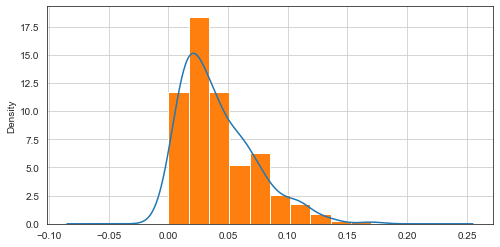

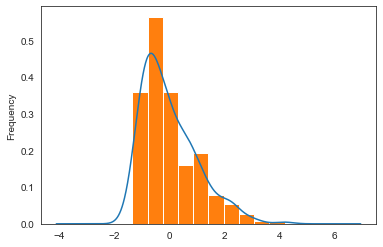

In [98]:
drop_mean = df_drop.percent_drop.mean()
drop_std = df_drop.percent_drop.std()
scaled = (df_drop.percent_drop - drop_mean) / drop_std

plt.figure(figsize=(8,4))
df_drop.percent_drop.plot.kde()
df_drop.percent_drop.hist(density=True)
plt.show()

scaled.plot.kde()
scaled.plot.hist(density=True)
plt.show()

In [99]:
mask = df.sold_over_asking == True
df_price_change = df.copy()

df.insert(0, 'percent_change', np.round((df.sell_price - df.ask_price) / df.ask_price, 4))

df.head()

,percent_change,listing,address,city,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,pps,sold_year,sold_month,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old,sold_at_asking,sold_over_asking,sold_under_asking
0,-0.067,R2444219,# 901 3740 ALBERT STREET,Burnaby,2,1,1,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",599,2020,3,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,-0.044,R2451408,# 607 3760 ALBERT STREET,Burnaby,1,1,1,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",533,2020,6,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,-0.021,R2452612,# 201 3740 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",490,2020,5,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,-0.028,R2436217,# 405 3760 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",578,2020,2,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4,0.000,R2463150,# 108 3709 PENDER STREET,Burnaby,1,1,1,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",564,2020,6,0,0,0,0,0,0,0,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [100]:
df.percent_change.describe()

count   339.000
mean     -0.028
std       0.041
min      -0.171
25%      -0.052
50%      -0.025
75%      -0.007
max       0.140
Name: percent_change, dtype: float64

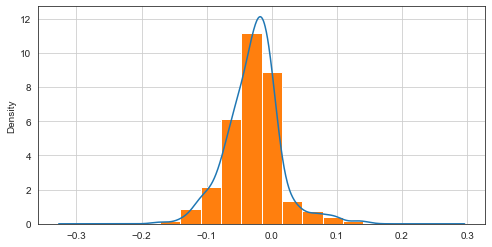

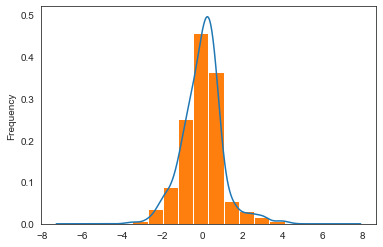

In [101]:
mean = df.percent_change.mean()
std = df.percent_change.std()
scaled = (df.percent_change - mean) / std

plt.figure(figsize=(8,4))
df.percent_change.plot.kde()
df.percent_change.hist(density=True)
plt.show()

scaled.plot.kde()
scaled.plot.hist(density=True)
plt.show()

In [102]:
df.head()

,percent_change,listing,address,city,beds,baths,property_type,unit_type,sold_date,sell_price,ask_price_final,ask_price,sqft,age,property_tax,ownership_type,maintenance_fee,rules,pps,sold_year,sold_month,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old,sold_at_asking,sold_over_asking,sold_under_asking
0,-0.067,R2444219,# 901 3740 ALBERT STREET,Burnaby,2,1,1,Upper Unit,2020-03-23,490000,525000,525000,877,36,2149.720,Freehold Strata,344.100,"Pets Not Allowed, Rentals Allowed with Restric...",599,2020,3,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,-0.044,R2451408,# 607 3760 ALBERT STREET,Burnaby,1,1,1,Inside Unit,2020-06-05,358500,374900,374900,704,37,1871.300,Freehold Strata,241.600,"Pets Not Allowed, Rentals Allowed with Restric...",533,2020,6,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,-0.021,R2452612,# 201 3740 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-05-12,420000,429000,429000,876,36,1395.000,Freehold Strata,343.680,"Pets Not Allowed, Rentals Allowed with Restric...",490,2020,5,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,-0.028,R2436217,# 405 3760 ALBERT STREET,Burnaby,2,1,1,Inside Unit,2020-02-20,485000,499000,499000,864,38,2155.410,Freehold Strata,369.000,"Pets Not Allowed, Rentals Allowed with Restric...",578,2020,2,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4,0.000,R2463150,# 108 3709 PENDER STREET,Burnaby,1,1,1,1 Storey,2020-06-10,440000,439900,439900,780,26,2020.050,Freehold Strata,240.280,"Pets Allowed, Pets Allowed with Restrictions, ...",564,2020,6,0,0,0,0,0,0,0,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [103]:
# Drop columns we don't need
columns = ['ask_price_final','listing','rules','address','city','unit_type','sold_date', 'ownership_type', 'age', 
           'pps','sold_month','sold_year','property_type','sold_over_asking','sold_under_asking','sold_at_asking']

drop_columns(columns)

In [104]:
df.columns

Index(['percent_change', 'beds', 'baths', 'sell_price', 'ask_price', 'sqft',
       'property_tax', 'maintenance_fee', 'ground_unit', 'penthouse_unit',
       'studio_unit', 'corner_unit', 'end_unit', 'upper_unit', 'inside_unit',
       'townhouse', 'age_restricted', 'rentals_allowed', 'pets_allowed',
       'no_smoking', 'no_restrictions', 'zoning_compdev', 'zoning_residential',
       'neighbourhood_Brentwood Park', 'neighbourhood_Burnaby Hospital',
       'neighbourhood_Capitol Hill BN', 'neighbourhood_Cariboo',
       'neighbourhood_Central BN', 'neighbourhood_Central Park BS',
       'neighbourhood_Edmonds BE', 'neighbourhood_Forest Glen BS',
       'neighbourhood_Forest Hills BN', 'neighbourhood_Government Road',
       'neighbourhood_Greentree Village', 'neighbourhood_Highgate',
       'neighbourhood_Metrotown', 'neighbourhood_Montecito',
       'neighbourhood_Oaklands', 'neighbourhood_Parkcrest',
       'neighbourhood_Simon Fraser Hills',
       'neighbourhood_Simon Fraser Univ

In [105]:
df.groupby(['zoning_compdev','zoning_residential'])['sell_price'].agg(['mean', 'count'])

,,mean,count
zoning_compdev,zoning_residential,,
0,1,486525.407,118
1,0,483665.222,221


### Two different models
1. If you want to see if you paid too much or little for a place than include the percent_change column
2. If you want the model to weigh in other features more, exclude the percent_change and ask_price

In [106]:
drop_columns(['percent_change', 'ask_price']) 

In [107]:
df.columns

Index(['beds', 'baths', 'sell_price', 'sqft', 'property_tax',
       'maintenance_fee', 'ground_unit', 'penthouse_unit', 'studio_unit',
       'corner_unit', 'end_unit', 'upper_unit', 'inside_unit', 'townhouse',
       'age_restricted', 'rentals_allowed', 'pets_allowed', 'no_smoking',
       'no_restrictions', 'zoning_compdev', 'zoning_residential',
       'neighbourhood_Brentwood Park', 'neighbourhood_Burnaby Hospital',
       'neighbourhood_Capitol Hill BN', 'neighbourhood_Cariboo',
       'neighbourhood_Central BN', 'neighbourhood_Central Park BS',
       'neighbourhood_Edmonds BE', 'neighbourhood_Forest Glen BS',
       'neighbourhood_Forest Hills BN', 'neighbourhood_Government Road',
       'neighbourhood_Greentree Village', 'neighbourhood_Highgate',
       'neighbourhood_Metrotown', 'neighbourhood_Montecito',
       'neighbourhood_Oaklands', 'neighbourhood_Parkcrest',
       'neighbourhood_Simon Fraser Hills',
       'neighbourhood_Simon Fraser Univer.', 'neighbourhood_South Slop

In [108]:
df.shape

(339, 49)

In [109]:
df.to_csv('abt_burnaby_6m.csv', index=None)

### Save dataset as Analytical Base Table

## Algorithm Selection
We are going to be predicting a continuous variable (sell_price) so we will be using a regression algorithm for the task. To pick the best regression parameter for the job with the best hyperparameters we will use a GridSearchCV and pass in different lists of settings for each algorithm.

We will pick the algorithm that has the lowest Mean Absolute Error (MAE). We will also factor in model score and R2 score

## Model Training

### Read in Analytical Base Table

In [110]:
df = pd.read_csv('abt_burnaby_6m.csv')

print(df.shape)

(339, 49)


In [111]:
df.head()

,beds,baths,sell_price,sqft,property_tax,maintenance_fee,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old
0,2,1,490000,877,2149.720,344.100,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,1,358500,704,1871.300,241.600,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,2,1,420000,876,1395.000,343.680,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,2,1,485000,864,2155.410,369.000,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,1,440000,780,2020.050,240.280,0,0,0,0,0,0,0,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [112]:
df.describe()

,beds,baths,sell_price,sqft,property_tax,maintenance_fee,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old
count,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000,339.000
mean,1.590,1.354,484660.802,817.425,2031.045,303.304,0.077,0.047,0.009,0.215,0.027,0.295,0.177,0.109,0.003,0.799,0.743,0.038,0.029,0.652,0.348,0.139,0.006,0.024,0.038,0.015,0.068,0.024,0.038,0.018,0.097,0.006,0.086,0.195,0.012,0.006,0.009,0.024,0.074,0.056,0.032,0.018,0.006,0.012,0.156,0.159,0.121,0.354,0.209
std,0.620,0.526,75018.212,200.731,331.616,82.213,0.267,0.212,0.094,0.412,0.161,0.457,0.382,0.312,0.054,0.401,0.437,0.192,0.169,0.477,0.477,0.346,0.077,0.152,0.192,0.121,0.252,0.152,0.192,0.132,0.297,0.077,0.280,0.397,0.108,0.077,0.094,0.152,0.262,0.230,0.177,0.132,0.077,0.108,0.364,0.366,0.327,0.479,0.408
min,0.000,1.000,265000.000,393.000,239.740,133.240,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,435000.000,678.000,1874.060,240.940,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2.000,1.000,489000.000,803.000,2086.430,293.350,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2.000,2.000,548250.000,935.500,2273.495,355.335,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
max,3.000,3.000,600000.000,1457.000,2879.640,681.950,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [113]:
y = df.sell_price
X = df.drop(['sell_price'], axis=1)

In [114]:
print(y.shape)
print(X.shape)

print(X.columns)

(339,)
(339, 48)
Index(['beds', 'baths', 'sqft', 'property_tax', 'maintenance_fee',
       'ground_unit', 'penthouse_unit', 'studio_unit', 'corner_unit',
       'end_unit', 'upper_unit', 'inside_unit', 'townhouse', 'age_restricted',
       'rentals_allowed', 'pets_allowed', 'no_smoking', 'no_restrictions',
       'zoning_compdev', 'zoning_residential', 'neighbourhood_Brentwood Park',
       'neighbourhood_Burnaby Hospital', 'neighbourhood_Capitol Hill BN',
       'neighbourhood_Cariboo', 'neighbourhood_Central BN',
       'neighbourhood_Central Park BS', 'neighbourhood_Edmonds BE',
       'neighbourhood_Forest Glen BS', 'neighbourhood_Forest Hills BN',
       'neighbourhood_Government Road', 'neighbourhood_Greentree Village',
       'neighbourhood_Highgate', 'neighbourhood_Metrotown',
       'neighbourhood_Montecito', 'neighbourhood_Oaklands',
       'neighbourhood_Parkcrest', 'neighbourhood_Simon Fraser Hills',
       'neighbourhood_Simon Fraser Univer.', 'neighbourhood_South Slope',


In [115]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

print(len(X_train), len(X_test), len(y_train), len(y_test))

271 68 271 68


In [116]:
pipelines = {
    'lm': make_pipeline(LinearRegression()),
    'lasso': make_pipeline(StandardScaler(),Lasso(random_state=123)),
    'ridge': make_pipeline(StandardScaler(),Ridge(random_state=123)),
    'enet': make_pipeline(StandardScaler(),ElasticNet(random_state=123)),
    'rf': make_pipeline(StandardScaler(),RandomForestRegressor(random_state=123)),
    'gb': make_pipeline(StandardScaler(),GradientBoostingRegressor(random_state=123))
}

In [117]:
lasso_hyperparameters = {
    'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}

ridge_hyperparameters = {
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}

enet_hyperparameters = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

rf_hyperparameters = { 
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]
}

gb_hyperparameters = {
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
} 
    
hyperparameters = {
    'lm': {},
    'lasso': lasso_hyperparameters,
    'ridge': ridge_hyperparameters,
    'enet': enet_hyperparameters,
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters
}

In [118]:
X_train.head()

,beds,baths,sqft,property_tax,maintenance_fee,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old
206,3,3,987,2048.410,478.320,1,0,0,0,0,0,0,0.000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
168,2,2,874,1859.990,396.820,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
140,2,2,812,2371.000,355.670,0,0,0,1,0,0,0,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
219,1,1,750,1907.650,236.300,0,0,0,0,0,0,1,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
218,1,1,584,935.180,235.850,0,0,0,0,0,0,0,0.000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [119]:
fitted_models = {}

# Run other regression algorithms
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name]=model
    
    print(name, 'has been fitted')

lm has been fitted
lasso has been fitted
ridge has been fitted
enet has been fitted
rf has been fitted
gb has been fitted


### Results

The model with both the following is the best:
- Highest R2 score 
- Lowest Mean Absolute Error score

In [120]:
print('Model Best Scores:')
for name, model in fitted_models.items():
    print(name, model.best_score_)

Model Best Scores:
lm 0.7111464642052756
lasso 0.7113493593979435
ridge 0.7178231662168816
enet 0.7178749874625806
rf 0.78727134331528
gb 0.7693139333720954


In [121]:
mae_scores = {}

print('Model R2, MSE, MAE Scores:')
for key, model in fitted_models.items():
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
        
    mae_scores[key] = mae
    
    print(key)
    
    print('------')
    print('R2', r2_score(y_test, pred))
    print('MSE', mean_squared_error(y_test, pred))
    print('MAE', mae)
    print('')


Model R2, MSE, MAE Scores:
lm
------
R2 0.7546219586860323
MSE 1390240614.0327573
MAE 28175.11799579708

lasso
------
R2 0.7549883058337229
MSE 1388164997.6457846
MAE 28162.7744007809

ridge
------
R2 0.7574805920113047
MSE 1374044429.0435061
MAE 28092.40310594945

enet
------
R2 0.7569129557055883
MSE 1377260491.2550254
MAE 28196.09817618834

rf
------
R2 0.8125544939414351
MSE 1062011718.9178426
MAE 25070.300441176467

gb
------
R2 0.8303846446559618
MSE 960991270.8576872
MAE 22711.411523358314



In [122]:
# Winning also
winner = min(mae_scores, key=mae_scores.get)
print(winner)

gb


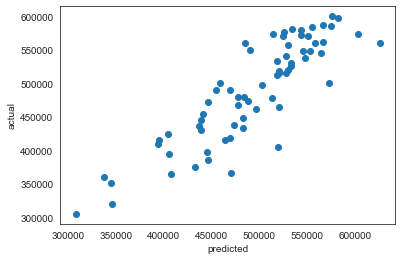

In [123]:
# Plot model with highest R2 and lowest MAE score so we will plot results
pred = fitted_models['lasso'].predict(X_test)
plt.scatter(pred, y_test)
#plt.plot(X, , 'k')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

### Save Trained Model using Pickle

In [124]:
# Save winning model as final_model.pkl
with open('final_model_without_ask.pkl', 'wb') as f:
    pickle.dump(fitted_models[winner].best_estimator_, f)

## Insights & Analysis

## Run Realestate Model
Pass in new unseen data and run against the loaded model we created using the Model training Notebook. This module will include a class that take in the saved model, and will clean and create missing features

In [125]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

# Pickle for reading model files
import pickle

# Scikit-Learn's train_test_split function
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Model

In [126]:
# Load final_model.pkl as model
with open('final_model_without_ask.pkl', 'rb') as f:
    model = pickle.load(f)

In [127]:
print(model)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.05, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200,
                                           n_iter_no_change=

### Confirm model

In [128]:
abt = pd.read_csv('abt_burnaby_6m.csv')

In [129]:
abt.head()
abt.index

RangeIndex(start=0, stop=339, step=1)

In [130]:
print(abt.shape)

(339, 49)


In [131]:
print(abt.columns)

Index(['beds', 'baths', 'sell_price', 'sqft', 'property_tax',
       'maintenance_fee', 'ground_unit', 'penthouse_unit', 'studio_unit',
       'corner_unit', 'end_unit', 'upper_unit', 'inside_unit', 'townhouse',
       'age_restricted', 'rentals_allowed', 'pets_allowed', 'no_smoking',
       'no_restrictions', 'zoning_compdev', 'zoning_residential',
       'neighbourhood_Brentwood Park', 'neighbourhood_Burnaby Hospital',
       'neighbourhood_Capitol Hill BN', 'neighbourhood_Cariboo',
       'neighbourhood_Central BN', 'neighbourhood_Central Park BS',
       'neighbourhood_Edmonds BE', 'neighbourhood_Forest Glen BS',
       'neighbourhood_Forest Hills BN', 'neighbourhood_Government Road',
       'neighbourhood_Greentree Village', 'neighbourhood_Highgate',
       'neighbourhood_Metrotown', 'neighbourhood_Montecito',
       'neighbourhood_Oaklands', 'neighbourhood_Parkcrest',
       'neighbourhood_Simon Fraser Hills',
       'neighbourhood_Simon Fraser Univer.', 'neighbourhood_South Slop

In [132]:
y = abt.sell_price
X = abt.drop('sell_price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=1234)

In [133]:
pred = model.predict(X_test)
pred

array([423132.06702882, 435944.57198699, 518664.24709439, 419309.67016976,
       417709.28332685, 507719.03439757, 404855.54858943, 564594.40198243,
       525505.38868576, 460596.75173848, 419559.93335106, 480116.84498263,
       569814.82796688, 453043.72352495, 553981.53107065, 526199.04645081,
       450407.46478204, 439956.71592724, 582895.21090582, 408266.78288986,
       343426.35807768, 418015.97952157, 435745.90394436, 547073.04696394,
       485225.90511163, 516355.94627898, 514945.05448177, 572130.05102587,
       561265.25533486, 544571.41168701, 466856.28005098, 476180.49766718,
       439139.22149966, 578703.91042407, 550803.88052089, 544688.93734083,
       408912.35031597, 314268.69682483, 516977.60184865, 434609.72922754,
       460982.35242561, 509637.5855438 , 561748.89844643, 483322.6200524 ,
       575800.05308553, 422061.55026994, 550865.8863562 , 433354.12198781,
       575498.62117022, 549402.78976998, 521348.75003857, 406818.44662256,
       365291.31339643, 4

In [134]:
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print('R2', r2_score(y_test, pred))
print('MSE', mean_squared_error(y_test, pred))
print('MAE', mae)
print('')

R2 0.8303846446559618
MSE 960991270.8576872
MAE 22711.411523358314



### Create Realestate Model Class
This will be used to load, clean and engineer features on new data and return the predictions for it

In [135]:
 def remove_chars(chars, column):
    if (type(column[0]) != str):
        return column
    
    for c in chars:
        column = column.str.replace(c, '')
        
    return column
 

In [136]:
import random 
import datetime

class RealestateModel:
    
    def __init__(self, model_location, city):
        with open(model_location, 'rb') as f:
            self.model = pickle.load(f)
            
        self.city = city
            
        
    
    def predict(self, X_new, with_ask_price, clean=True, augment=True):
        df = X_new.copy()
        
        if clean:
            df = self.clean_data(df)
    
        if augment:
            df = self.engineer_features(df)
               
        step = 1
        df.index = pd.RangeIndex(start=0, stop=len(df.index) * step, step=step)  
        
        # drop sell price
        df.drop('sell_price', axis=1, inplace=True)
        
        if with_ask_price == False:
            print('Ask price droppped')
            df.drop('ask_price', axis=1, inplace=True)
        
        print(df.shape)
        pred = self.model.predict(df)
            
            
        return df, pred
    
    
    def clean_data(self, df):
       
        df.rename({'Listing': 'listing', 'Address': 'address', 'City': 'city', 'Neighbourhood': 'neighbourhood', 'Beds': 'beds', 'Baths': 'baths',
          'Property Type': 'property_type', 'Unit Type': 'unit_type', 'Sold Date': 'sold_date', 'Selling Price': 'sell_price', 
          'Asking Price (Final)': 'ask_price_final', 'Asking Price (Original)': 'ask_price', 'Sqft': 'sqft', 'Age': 'age',
          'Property Tax': 'property_tax', 'Ownership Type': 'ownership_type', 'Maintenance Fee': 'maintenance_fee', 'Rules': 'rules',
          'Zoning': 'zoning'}, axis=1, inplace=True)
        
        df.sqft = remove_chars(['$',','], df.sqft)
        df.sell_price = remove_chars(['$', ','], df.sell_price)
        df.ask_price = remove_chars(['$', ','], df.ask_price)
        df.ask_price_final = remove_chars(['$', ','], df.ask_price_final)
        df.maintenance_fee = remove_chars(['$', ','], df.maintenance_fee)
        df.property_tax = remove_chars(['$', ','], df.property_tax)

        df.loc[df.age == 'Old', 'age'] = str(random.randint(26,39))
        df.loc[df.age == 'New', 'age'] = str(random.randint(0,5))
      
        df.sqft = df.sqft.astype('int64')
        df.beds = df.beds.astype('int64')
        df.baths = df.baths.astype('int64')
        df.age = df.age.astype('int64')
        
        # The orignal data used to construct model included sold price, but we do not have
        # this and a few other pieces of data when scrapping activ listings
        if ~df.sell_price.isnull().any():
            print('Condition Hit')
            df.sell_price = df.sell_price.astype('int64')
            df.ask_price_final = df.ask_price_final.astype('int64')
            df.sold_date = df.sold_date.astype('datetime64')
              
        df.ask_price = df.ask_price.astype('int64')
        df.maintenance_fee = df.maintenance_fee.astype('float64')
        df.property_tax = df.property_tax.astype('float64')
   
        df.drop_duplicates(inplace=True)
        
        if self.city != None:
            mask = df.city == self.city
            df = df[mask].copy()
                        
        df.replace(['MIXED','MF','M/F','MFD','ROWHOU','TOWNHO','RM1','RM5','RMS','RM2','RM-5','RM-4','RM/4','RM-4N','RM 9A','FM-1','RM3','RM-9A','RM-3A','RM-3','RM4','RS-1', 'RM','RM-9N','MF','STRATA','APT','CONDO','MULTI','RES','MC-1', 'VA', '-'], 'Residential', inplace=True)
        df.replace(['C9A','C2C1','C2-C1','C-2B', 'C3A','C-3A C','C-7','C-C21','C-2C1','C1','IC-3','C3-A','C-2C','C-1','C2','C-2','C-3A','C2-C'],'Commerical', inplace=True)
        df.replace(['CDRM3S','CD/RM3','CD RM3','P11','P11E','A.CD','CDRM5','CD-RM5', 'CDRM1','CDP11','CD, C9','CD RMS','CD,C9','CD RM5','CDRM-5','CD,RM3','CD,RM2','CD-APT','CD-1','CD','CD - 1','FCCDD','CD1'],'CompDev', inplace=True)
            
        df = df[df.property_tax.isnull() == False].copy()
        df.loc[df.unit_type.isnull() == True, 'unit_type'] = 'Townhouse'
        df.loc[df.rules.isnull(), 'rules'] = 'No Restrictions'
        
        df.dropna(subset=['maintenance_fee'], inplace=True)
        
        df.replace('Apartment', 1, inplace=True)
        df.replace('Townhouse', 2, inplace=True)
        df.property_type = df.property_type.astype('int64')
        
        if self.city == 'Burnaby':
            df.loc[df.neighbourhood == 'Sperling-Duthie', 'neighbourhood'] = 'Westridge BN'
        elif self.city == 'Vancouver':
            df.neighbourhood.replace('Fraser VE', 'Fraserview VE', inplace=True)
            df.neighbourhood.replace('Hastings', 'Hastings Sunrise', inplace=True)
               
        return df 

    
    def engineer_features(self, df):
        
        # Since we use sold date, we are just going to fill missing values with today's date and month
        if ~df.sold_date.isnull().any():
            df['sold_year'] = pd.DatetimeIndex(df['sold_date']).year
            df['sold_month'] = pd.DatetimeIndex(df['sold_date']).month
        else:
            now = datetime.datetime.now()
            df['sold_year'] = now.year
            df['sold_month'] = now.month
        
        df['ground_unit'] = (df.unit_type.str.contains('Ground', na=False)==True).astype('int64')
        df['penthouse_unit'] = (df.unit_type.str.contains('Penthouse', na=False)==True).astype('int64')
        df['studio_unit'] = (df.unit_type.str.contains('Studio', na=False)==True).astype('int64')
        df['corner_unit'] = (df.unit_type.str.contains('Corner', na=False)==True).astype('int64')
        df['end_unit'] = (df.unit_type.str.contains('End', na=False)==True).astype('int64')
        df['upper_unit'] = (df.unit_type.str.contains('Upper', na=False)==True).astype('int64')
        df['inside_unit'] = (df.unit_type.str.contains('Inside', na=False)==True).astype('int64')
        df['townhouse'] = (df.property_type[df.property_type == 2] == 2).astype('int64')
        
        df.townhouse.fillna(0, inplace=True)
        
        df['age_restricted'] = (df.rules.str.contains('Age Restrictions', na=False)==True).astype('int64')
        df['rentals_allowed'] = (df.rules.str.contains('Rentals Allowed', na=False)==True).astype('int64')
        df['pets_allowed'] = (df.rules.str.contains('Pets Allowed', na=False)==True).astype('int64')
        df['no_smoking'] = (df.rules.str.contains('Smoking Restrictions', na=False)==True).astype('int64')
        df['no_restrictions'] = (df.rules.str.contains('No Restrictions', na=False)==True).astype('int64')
        
        df.ownership_type.replace(['Leasehold prepaid-NonStrata','Leasehold prepaid-Strata',
                          'Shares in Co-operative','Undivided Interest', 'First Nations Lease',
                          'Freehold NonStrata'], 'Other', inplace=True)
        # Bin age into the following groups
        df['building_age'] = None

        new = df.age.between(0, 5, inclusive=True)
        df.loc[new,'building_age']='New'

        newish = df.age.between(6, 12, inclusive=True)
        df.loc[newish,'building_age']='Newish'

        lived_in = df.age.between(13, 25, inclusive=True)
        df.loc[lived_in,'building_age']='Lived In'

        old = df.age.between(26, 39,  inclusive=True)
        df.loc[old,'building_age']='Old'

        very_old = df.age >= 40
        df.loc[very_old,'building_age']='Very Old'
                
        # rank if unit sold over,under, or same as ask price
        under_asking = df.sell_price < df.ask_price
        over_asking = df.sell_price > df.ask_price
        at_asking = df.sell_price == df.ask_price

        df.loc[under_asking,'sold']='under_asking'
        df.loc[over_asking,'sold']='over_asking'
        df.loc[at_asking,'sold']='at_asking'
        
        df =  pd.get_dummies(df, columns=['zoning','neighbourhood','building_age','sold'])

        df.rename({'zoning_Commerical': 'zoning_commerical'}, axis=1, inplace=True)
        df.rename({'zoning_CompDev': 'zoning_compdev'}, axis=1, inplace=True)
        df.rename({'zoning_Residential': 'zoning_residential'}, axis=1, inplace=True)
        df.rename({'ownership_type_Freehold NonStrata': 'freehold_nonstrata'}, axis=1, inplace=True)
        df.rename({'ownership_type_Freehold Strata': 'freehold_strata'}, axis=1, inplace=True)
        df.rename({'ownership_type_Leasehold prepaid-NonStrata': 'leasehold_prepaid_nonstrata'}, axis=1, inplace=True)
        df.rename({'ownership_type_Leasehold prepaid-Strata': 'leasehold_prepaid_strata'}, axis=1, inplace=True)
        df.rename({'ownership_type_Shares in Co-operative': 'shares_in_coooperative'}, axis=1, inplace=True)
        df.rename({'ownership_type_Undivided Interest': 'undivided_interest'}, axis=1, inplace=True)

        #df.insert(0, 'percent_change', np.round((df.sell_price - df.ask_price) / df.ask_price, 4))
                
        df.drop(['ask_price_final','listing','rules','address','city','unit_type','sold_date', 'ownership_type', 'age', 
           'sold_month','sold_year','property_type', 'sold_over_asking','sold_under_asking','sold_at_asking'], axis=1, inplace=True)
                
        return df   
    

In [137]:
def analysis_with_ask_price(df, df_combined, pred):
    df_new = df.copy()
    yhat = np.round(pred, 0).astype(int)
  
    df_new.insert(0, 'listing', df_combined.listing)
    df_new.insert(1, 'sold_for', df_combined.sell_price)
    df_new.insert(2, 'pred_sell_price', yhat)
    df_new.insert(3, 'price_diff', yhat - df_new.ask_price)
    df_new.insert(4, 'percent_diff', np.round(((yhat - df_new.ask_price) / yhat) * 100, 2))
    
    return df_new


def analysis_without_ask_price(df, ask_price, pred):
    df_new = df.copy()
    yhat = np.round(pred, 0).astype(int)
    
    df_new.insert(0, 'listing', df_combined.listing)
    df_new.insert(1, 'sold_for', df_combined.sell_price)
    df_new.insert(2, 'pred_sell_price', yhat)
    df_new.insert(3, 'ask_price', df_combined.ask_price)
    df_new.insert(4, 'price_diff', yhat - df_combined.ask_price)
    df_new.insert(5, 'percent_diff', np.round(((yhat - df_combined.ask_price) / yhat) * 100, 2))
    
    return df_new

### Run Model on Unseen Data
Sold data is different than non-sold data

It seems you need to combine the new data with data you made model with so you can generate the indicator columns
for some of the columns.

In [139]:
# Use this to select between model with ask_price and without ask_price
with_ask_price = False
city = 'Burnaby'

# Load scrapped data (same as you would in 1 - Exploratory)
df_new = pd.read_csv('burnaby_actives.csv')

# Load data you used to train model from the cleaned stage
# This is so you have all the data used to generate indicator variables
df_old_cleaned = pd.read_csv('cleaned_burnaby_6m.csv')

In [141]:
# clean new data and combine with stage two data used for abt
if with_ask_price == True:
    print('Loading model with ask_price')
    realestate_model = RealestateModel('final_model_with_ask.pkl', city)
else:
    print('Loading model without ask_price')
    realestate_model = RealestateModel('final_model_no_ask.pkl', city)
    
df_new_cleaned = realestate_model.clean_data(df_new)

df_combined = pd.concat([df_new_cleaned, df_old_cleaned])
df_combined.reset_index(drop=True, inplace=True)

df_combined.head()
print(df_combined.shape)

Loading model without ask_price
(343, 19)


C:\Users\bobeep\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [142]:
# engineer features on entire dataset
df_new_data = realestate_model.engineer_features(df_combined)

In [143]:
print(df_new_data.shape)
df_new_data.columns

(343, 50)


Index(['beds', 'baths', 'sell_price', 'ask_price', 'sqft', 'property_tax',
       'maintenance_fee', 'ground_unit', 'penthouse_unit', 'studio_unit',
       'corner_unit', 'end_unit', 'upper_unit', 'inside_unit', 'townhouse',
       'age_restricted', 'rentals_allowed', 'pets_allowed', 'no_smoking',
       'no_restrictions', 'zoning_compdev', 'zoning_residential',
       'neighbourhood_Brentwood Park', 'neighbourhood_Burnaby Hospital',
       'neighbourhood_Capitol Hill BN', 'neighbourhood_Cariboo',
       'neighbourhood_Central BN', 'neighbourhood_Central Park BS',
       'neighbourhood_Edmonds BE', 'neighbourhood_Forest Glen BS',
       'neighbourhood_Forest Hills BN', 'neighbourhood_Government Road',
       'neighbourhood_Greentree Village', 'neighbourhood_Highgate',
       'neighbourhood_Metrotown', 'neighbourhood_Montecito',
       'neighbourhood_Oaklands', 'neighbourhood_Parkcrest',
       'neighbourhood_Simon Fraser Hills',
       'neighbourhood_Simon Fraser Univer.', 'neighbourho

In [144]:
# generate predictions
X_new, pred = realestate_model.predict(df_new_data, with_ask_price, clean=False, augment=False)

df = None

if with_ask_price == True:
    df = analysis_with_ask_price(X_new, df_combined, pred)
else: 
    df = analysis_without_ask_price(X_new, df_combined, pred)
       

Ask price droppped
(343, 48)


In [145]:
pd.set_option('display.max_rows', None)

In [146]:
# The top four rows show the predictions for the unseen data
df.head(10)

,listing,sold_for,pred_sell_price,ask_price,price_diff,percent_diff,beds,baths,sqft,property_tax,maintenance_fee,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old
0,R2459958,nan,421087,489000,-67913,-16.130,2,1,885,1895.980,330.610,1,0,0,0,0,0,0,0.000,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,R2472749,nan,338132,324900,13232,3.910,1,1,710,1643.680,338.460,0,0,0,0,0,0,1,0.000,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,R2471373,nan,387010,498000,-110990,-28.680,2,1,864,1822.540,334.470,0,0,0,1,1,0,0,0.000,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,R2473202,nan,378283,409000,-30717,-8.120,1,1,821,1811.180,311.170,1,0,0,0,0,0,0,0.000,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,R2444219,490000.000,484876,525000,-40124,-8.280,2,1,877,2149.720,344.100,0,0,0,0,0,1,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,R2451408,358500.000,403034,374900,28134,6.980,1,1,704,1871.300,241.600,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,R2452612,420000.000,410648,429000,-18352,-4.470,2,1,876,1395.000,343.680,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,R2436217,485000.000,483252,499000,-15748,-3.260,2,1,864,2155.410,369.000,0,0,0,0,0,0,1,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8,R2463150,440000.000,445625,439900,5725,1.280,1,1,780,2020.050,240.280,0,0,0,0,0,0,0,0.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9,R2431467,430000.000,424383,448888,-24505,-5.770,1,1,730,1991.640,240.000,0,0,0,0,0,0,0,1.000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [147]:
df.sort_values('percent_diff', ascending=False).head()

,listing,sold_for,pred_sell_price,ask_price,price_diff,percent_diff,beds,baths,sqft,property_tax,maintenance_fee,ground_unit,penthouse_unit,studio_unit,corner_unit,end_unit,upper_unit,inside_unit,townhouse,age_restricted,rentals_allowed,pets_allowed,no_smoking,no_restrictions,zoning_compdev,zoning_residential,neighbourhood_Brentwood Park,neighbourhood_Burnaby Hospital,neighbourhood_Capitol Hill BN,neighbourhood_Cariboo,neighbourhood_Central BN,neighbourhood_Central Park BS,neighbourhood_Edmonds BE,neighbourhood_Forest Glen BS,neighbourhood_Forest Hills BN,neighbourhood_Government Road,neighbourhood_Greentree Village,neighbourhood_Highgate,neighbourhood_Metrotown,neighbourhood_Montecito,neighbourhood_Oaklands,neighbourhood_Parkcrest,neighbourhood_Simon Fraser Hills,neighbourhood_Simon Fraser Univer.,neighbourhood_South Slope,neighbourhood_Sullivan Heights,neighbourhood_Vancouver Heights,neighbourhood_Westridge BN,neighbourhood_Willingdon Heights,building_age_Lived In,building_age_New,building_age_Newish,building_age_Old,building_age_Very Old
71,R2442694,366000.000,435746,360000,75746,17.380,2,1,953,1827.360,207.370,0,0,0,0,0,0,0,1.000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
236,R2428439,437500.000,460982,399999,60983,13.230,1,1,678,2086.430,309.860,0,0,0,0,0,0,0,0.000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
120,R2429094,456000.000,459196,399900,59296,12.910,2,2,883,1854.510,356.440,0,0,0,1,0,0,0,0.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
161,R2445859,365000.000,419310,368000,51310,12.240,2,1,733,1686.230,325.700,0,0,0,1,0,0,0,0.000,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
163,R2456019,400500.000,422409,373000,49409,11.700,2,1,878,1905.840,382.610,0,0,0,0,0,0,0,0.000,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [156]:
len(df[df.pred_sell_price < df.sold_for])

170

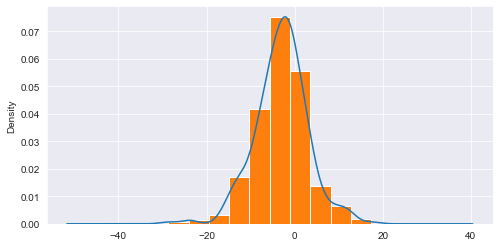

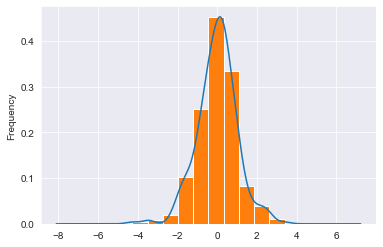

In [152]:
plt.figure(figsize=(8,4))
df.percent_diff.plot.kde()
df.percent_diff.hist(density=True)
plt.show()

mean = df.percent_diff.mean()
std = df.percent_diff.std()
scaled = (df.percent_diff - mean) / std

scaled.plot.kde()
scaled.plot.hist(density=True)
plt.show()

In [153]:
scaled.describe().round(2)

count   343.000
mean      0.000
std       1.000
min      -4.280
25%      -0.590
50%       0.040
75%       0.560
max       3.390
Name: percent_diff, dtype: float64

In [154]:
df.percent_diff.describe()

count   343.000
mean     -2.993
std       6.008
min     -28.680
25%      -6.520
50%      -2.770
75%       0.395
max      17.380
Name: percent_diff, dtype: float64

In [155]:
df.price_diff.describe()

count       343.000
mean     -14805.455
std       28529.438
min     -115502.000
25%      -30398.500
50%      -13390.000
75%        1776.500
max       75746.000
Name: price_diff, dtype: float64

### Summary

The winning algorithm was Gradient Boosting with the following:

R2 0.8303846446559618
MSE 960991270.8576872
MAE 22711.411523358314

The sell_price can be predicted within 22711 of actual price in one standard deviation about 68% since graph is quite similar to normal distribution

The average percent difference is -2.993% meaning on average places sold for a price reduction of that percentage. The standard deviation is +/- 6% so the range is about -9% to 3%  of asking price. 

Half of the predicted prices were under the actual selling price and half were over the actual selling price.

I think based on these results you could use this model to see if a unit is over or undervalued, but you also need to take a closer look and factor in unit conditions, strata insurance (levies coming) up or distressed units that are in foreclosure.